### Import relevant packages, establish connection to WRDS and set overall configurations for the notebook

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import wrds
import yfinance as yf 
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import sklearn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from scipy.stats import skew, kurtosis
import pywt


# Build WRDS connection
db = wrds.Connection(wrds_username='tomasromeiro')
#db.close()

# Set option to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set option to force dataframes to display numbers as floats with thousands separators
pd.set_option('display.float_format', '{:,.3f}'.format)  # Adjust decimal places as needed

/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading library list...
Done


WRDS Quick commands - https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/querying-wrds-data-python/

In [ ]:
# List libraries available
sorted(db.list_libraries()) 

# List tables within a library
db.list_tables(library="comp_na_daily_all") 

# describe table metadata
db.describe_table(library="comp_na_daily_all", table="secd") 

# Execute a sql query against a table (join queries between tables in library can also be performed)
data = db.raw_sql('SELECT date, dji FROM djones.djdaily LIMIT 1', date_cols=['date']) 

# Pass parameters to a sql statement
params = {"tickers": ("0015B", "0030B", "0032A", "0033A", "0038A")}
data = db.raw_sql(
    "SELECT datadate, gvkey, cusip FROM comp.funda WHERE tic IN %(tickers)s LIMIT 1",
    params=params,
)

Define start and end dates for the dataset

In [2]:
start_date = '2014-01-01'
end_date = '2025-03-01'

Scrape Wikipedia to download all the current and historical join and leave dates per ticker (this data has been removed from WRDS and cannot be found for free easily)

In [3]:
# --- Scrape current S&P 500 component stocks ---
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
response.raise_for_status()
soup = BeautifulSoup(response.content, 'html.parser')

# Locate the "S&P 500 component stocks" section by its anchor id or header text
header = soup.find(id="S&P_500_component_stocks")
if header is None:
    header = soup.find(lambda tag: tag.name.startswith("h") and "S&P 500 component stocks" in tag.get_text())
if header is None:
    raise Exception("Section 'S&P 500 component stocks' not found.")

table = header.find_next("table")
if table is None:
    raise Exception("Table not found after the section header.")

sp500_current_tickers = pd.read_html(str(table))[0]

# Flatten multi-index columns if necessary
if isinstance(sp500_current_tickers.columns, pd.MultiIndex):
    sp500_current_tickers.columns = [' '.join(map(str, col)).strip() for col in sp500_current_tickers.columns.values]
else:
    sp500_current_tickers.columns = [col.strip() if isinstance(col, str) else col for col in sp500_current_tickers.columns]

# Identify the ticker column (typically "Symbol" or "Ticker")
ticker_col_current = next((col for col in sp500_current_tickers.columns if "Symbol" in col or "Ticker" in col), None)
if ticker_col_current is None:
    raise Exception("Ticker column not found in current components table.")

# Identify the date-added column.
# Commonly this is "Date first added" but we check for other variants as well.
date_added_col_current = next((col for col in sp500_current_tickers.columns if "date" in col.lower() and "add" in col.lower()), None)

# Create a DataFrame for current tickers.
df_current = sp500_current_tickers[[ticker_col_current]].copy()
df_current = df_current.rename(columns={ticker_col_current: 'ticker'})
df_current['ticker'] = df_current['ticker'].str.strip()

if date_added_col_current is not None:
    df_current['added_date'] = pd.to_datetime(sp500_current_tickers[date_added_col_current], errors='coerce')
else:
    df_current['added_date'] = pd.NaT

# For current tickers, the removed date is unknown.
df_current['removed_date'] = pd.NaT

# --- Scrape changes to the S&P 500 components ---
# (Here we re-use the same URL; you can combine requests if desired.)
response = requests.get(url)
response.raise_for_status()
soup = BeautifulSoup(response.content, 'html.parser')

header = soup.find(id="Selected_changes_to_the_list_of_S&P_500_components")
if header is None:
    raise Exception("Section 'Selected changes to the list of S&P 500 components' not found.")

table = header.find_next("table")
if table is None:
    raise Exception("Table not found after the section header.")

df_changes = pd.read_html(str(table))[0]

# Flatten multi-index columns if needed.
if isinstance(df_changes.columns, pd.MultiIndex):
    df_changes.columns = [' '.join(map(str, col)).strip() for col in df_changes.columns.values]
else:
    df_changes.columns = [col.strip() if isinstance(col, str) else col for col in df_changes.columns]

# Identify key columns in the changes table.
date_col = next((col for col in df_changes.columns if "Date" in col), None)
added_col = next((col for col in df_changes.columns if "Added" in col), None)
removed_col = next((col for col in df_changes.columns if "Removed" in col), None)

if not date_col:
    raise Exception("Could not find a date column in the changes table.")
if not added_col:
    raise Exception("Could not find an 'Added' column in the changes table.")
if not removed_col:
    raise Exception("Could not find a 'Removed' column in the changes table.")

# Process added events.
df_add = df_changes[[date_col, added_col]].dropna(subset=[added_col]).copy()
df_add = df_add.rename(columns={date_col: 'added_date', added_col: 'ticker'})
df_add['added_date'] = pd.to_datetime(df_add['added_date'], errors='coerce')

# Process removed events.
df_removed = df_changes[[date_col, removed_col]].dropna(subset=[removed_col]).copy()
df_removed = df_removed.rename(columns={date_col: 'removed_date', removed_col: 'ticker'})
df_removed['removed_date'] = pd.to_datetime(df_removed['removed_date'], errors='coerce')

# Merge added and removed events on ticker via an outer join.
changes_df = pd.merge(df_add, df_removed, on='ticker', how='outer')
changes_df = changes_df[['ticker', 'added_date', 'removed_date']].reset_index(drop=True)

# --- Combine both sources ---
# Ensure tickers are stripped of whitespace.
df_current['ticker'] = df_current['ticker'].str.strip()
changes_df['ticker'] = changes_df['ticker'].str.strip()

# Concatenate current tickers and changes.
sp500_historical_tickers = pd.concat([df_current, changes_df], ignore_index=True)

# Drop exact duplicates; if the same ticker appears with different added_date values, both rows will be kept.
sp500_historical_tickers = sp500_historical_tickers.drop_duplicates().sort_values(by='ticker').reset_index(drop=True)

# Sort by ticker and added_date (with missing values placed last)
sp500_historical_tickers = sp500_historical_tickers.sort_values(by=['ticker', 'added_date'], na_position='last')

# Drop duplicates for each ticker, keeping the first occurrence (i.e. the row with the earliest added_date)
sp500_historical_tickers = sp500_historical_tickers.drop_duplicates(subset=['ticker'], keep='first')

/var/folders/6m/9c51nr553j7_3q44vsy7bg_c0000gn/T/ipykernel_461/4041757623.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500_current_tickers = pd.read_html(str(table))[0]
/var/folders/6m/9c51nr553j7_3q44vsy7bg_c0000gn/T/ipykernel_461/4041757623.py:62: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_changes = pd.read_html(str(table))[0]


### WRDS Data

#### Stock Data (Daily Level) - Prices and Volume
https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-daily/

Extract unique downloaded tickers and compare to unique ticker list derived so far. Delete unmatched tickers from previous datasets.

#### a) Download data
If the data has already been downloaded and treated do not run this and skip to opening the curated in the cell before we calculate the study periods. 

In [13]:
# Pass parameters to a sql statement
params = {
    "start_date": start_date,
    "end_date": end_date,
    "tickers": tuple(sp500_historical_tickers['ticker'])
}

# Query WRDS to fetch data
daily_stock_data_df = db.raw_sql(
    """
    SELECT DISTINCT a.datadate as date, a.conm as company_name, a.tic as ticker, c.industry, a.prccd as price_close, a.ajexdi, a.prccd / a.ajexdi as price_close_adj,
    a.cshtrd / a.ajexdi as volume_adj, a.cshoc as shares_outstanding, a.prccd * a.cshoc as market_cap 
    
    FROM comp_na_daily_all.secd a 
    
    LEFT JOIN (
               select conm, a.gvkey
                    , case when gsector = '10' then 'Energy'
                           when gsector = '15' then 'Materials'
                           when gsector = '20' then 'Industrials'
                           when gsector = '25' then 'Consumer Discretionary'
                           when gsector = '30' then 'Consumer Staples'
                           when gsector = '35' then 'Health Care'
                           when gsector = '40' then 'Financials'
                           when gsector = '45' then 'Information Technology'
                           when gsector = '50' then 'Communication Services'
                           when gsector = '55' then 'Utilities'
                           when gsector = '60' then 'Real Estate'
                        end as industry
               from comp_na_daily_all.company a
               left join comp_na_daily_all.r_giccd b
                  on a.gind = b.giccd
              ) c
        on c.gvkey = a.gvkey
    
    WHERE a.datadate between %(start_date)s AND %(end_date)s AND a.tic in %(tickers)s
    """,
    params=params
)

In [5]:
daily_stock_data_df.isna().sum()

date                     0
company_name             0
ticker                   0
industry              7084
price_close             14
ajexdi                  14
price_close_adj         14
volume_adj              72
shares_outstanding     239
market_cap             239
dtype: int64

In [14]:
# Ensure date columns are datetime objects
daily_stock_data_df['date'] = pd.to_datetime(daily_stock_data_df['date'])
sp500_historical_tickers['added_date'] = pd.to_datetime(sp500_historical_tickers['added_date'])
sp500_historical_tickers['removed_date'] = pd.to_datetime(sp500_historical_tickers['removed_date'])

# Merge daily stock data with the combined_df date info on ticker.
# We assume every ticker in daily_stock_data_df is in combined_df.
merged_df = daily_stock_data_df.merge(
    sp500_historical_tickers[['ticker', 'added_date', 'removed_date']],
    on='ticker',
    how='left'
)

# Apply the filtering conditions:
# - If added_date exists, keep only rows with date >= added_date.
# - If removed_date exists, keep only rows with date <= removed_date.
# - Otherwise, keep all rows.
daily_stock_data_df = merged_df[
    ((merged_df['added_date'].isna()) | (merged_df['date'] >= merged_df['added_date'])) &
    ((merged_df['removed_date'].isna()) | (merged_df['date'] <= merged_df['removed_date']))
]

In [8]:
daily_stock_data_df.isna().sum()

date                        0
company_name                0
ticker                      0
industry                    0
price_close                 7
ajexdi                      7
price_close_adj             7
volume_adj                 57
shares_outstanding         55
market_cap                 55
added_date             123031
removed_date          1159775
dtype: int64

### 2) Yahoo Finance Data

##### a) Market Data - S&P500, VIX, Bonds, Gold and Oil. If already downloaded, skip to opening the file in the next cell

In [24]:
# Define the directory containing the CSV files
directory = 'data/market_data'
output_file = os.path.join(directory, 'market_data.csv')

# # Check if the collated file already exists and delete it
if os.path.exists(output_file):     
    os.remove(output_file)

# Define ticker symbols
tickers = ["^GSPC", "^VIX", "^FVX", "^TNX", "^TYX", "GLD", "USO"]

# Fetch data (Closing Prices and Volume)
market_data_df = yf.download(tickers, start=start_date, end='2025-02-01', progress=False)[['Close']]

# Flatten the MultiIndex to standard column names
market_data_df.columns = [f"{col[0]}_{col[1]}" for col in market_data_df.columns]

# Rename columns to match the requested format
market_data_df = market_data_df.rename(columns={
    'Close_^GSPC': 'sp500_price_close',
    'Close_^VIX': 'vix_price_close',
    'Close_^TNX': 'tnx_price_close',
    'Close_GLD': 'gld_price_close',
    'Close_USO': 'uso_price_close'
})

# Reorder columns
market_data_df = market_data_df[['sp500_price_close', 'vix_price_close', 'tnx_price_close', 'gld_price_close', 'uso_price_close']]

# Format date index to YYYY-MM-DD and reset index
market_data_df.index = market_data_df.index.strftime('%Y-%m-%d')
market_data_df = market_data_df.reset_index()

# Rename the date column to 'date'
market_data_df = market_data_df.rename(columns={'index': 'date'})

# Compute daily returns as a fraction (e.g. 0.01 = 1%):
market_data_df['net_return'] = market_data_df['sp500_price_close'].pct_change()

# Remove or fill the first row if it is NaN, for example:
market_data_df.dropna(subset=['net_return'], inplace=True)

# Ensure Date is properly formated
market_data_df['Date'] = pd.to_datetime(market_data_df['Date'])

# Save the collated DataFrame to the same directory
market_data_df.to_csv(output_file, index=False)

YF.download() has changed argument auto_adjust default to True


In [24]:
# Define the directory containing the CSV files
directory = 'data/market_data'

# Open the file in a DataFrame for viewing
market_data_df = os.path.join(directory, 'market_data.csv')
market_data_df = pd.read_csv(market_data_df)

### 3) Clean / join datasets and compute additional metrics / feature engineering

a) Clean dataset

In [16]:
# 1. Clean tickers with null metrics
tickers_null = daily_stock_data_df.loc[(daily_stock_data_df['price_close'].isna()) | (daily_stock_data_df['market_cap'].isna()), 'ticker'].unique()
print("\nCount of tickers with null metrics is:", len(tickers_null))

daily_stock_data_df = daily_stock_data_df[~daily_stock_data_df['ticker'].isin(tickers_null)].copy()
print("DataFrame shape after removing tickers with null:", daily_stock_data_df.shape)
print("Total count of tickers is:", len(daily_stock_data_df['ticker'].unique()))

# 2. Check if there are any (date, ticker) level duplicates
daily_stock_data_df = daily_stock_data_df.sort_values(by=["ticker", "date"]).reset_index(drop=True) # Sort by ticker and date
dup_counts = daily_stock_data_df.groupby(['ticker', 'date']).size().reset_index(name='count') # Group by 'ticker' and 'date' and count the number of occurrences.
dup_pairs = dup_counts[dup_counts['count'] > 1] # Identify (ticker, date) pairs with more than 1 occurrence.
print(f"Count of tickers with duplicate (ticker, date) pairs: {len(dup_pairs['ticker'].unique())}.")

# 3. Drop unnecessary columns 
columns_to_drop = ['price_close', 'volume_adj', 'shares_outstanding', 'ajexdi', 'added_date', 'removed_date']
daily_stock_data_df.drop(columns=columns_to_drop, inplace=True)

# Final ticker count
tickers_count = daily_stock_data_df['ticker'].unique().tolist()
print(f"{len(tickers_count)} unique tickers after cleaning dataset. Dataframe shape {daily_stock_data_df.shape}")


Count of tickers with null metrics is: 30
DataFrame shape after removing tickers with null: (1313527, 12)
Total count of tickers is: 639
Count of tickers with duplicate (ticker, date) pairs: 0.
639 unique tickers after cleaning dataset. Dataframe shape (1313527, 6)


In [12]:
daily_stock_data_df.isna().sum()

date               0
company_name       0
ticker             0
industry           0
price_close_adj    0
market_cap         0
dtype: int64

In [13]:
# Group by year (extracted from the date column) and count unique tickers
distinct_tickers_per_year = daily_stock_data_df.groupby(daily_stock_data_df['date'].dt.year)['ticker'].nunique()

# Print the result
print(distinct_tickers_per_year)

date
2014    436
2015    453
2016    471
2017    480
2018    484
2019    493
2020    492
2021    499
2022    498
2023    505
2024    509
2025    496
Name: ticker, dtype: int64


c) Compute additional metrics

In [17]:
# -----------------------------------------------------------------------------
# 1. Data Preparation
# -----------------------------------------------------------------------------
# Assumes daily_stock_data_df has columns: 'date', 'ticker', 'price_close_adj'.
daily_stock_data_df['date'] = pd.to_datetime(daily_stock_data_df['date'])
daily_stock_data_df.sort_values(['ticker', 'date'], inplace=True)

# Compute simple daily returns: (price_today / price_yesterday - 1)
daily_stock_data_df['return'] = daily_stock_data_df.groupby('ticker')['price_close_adj'].pct_change()
daily_stock_data_df.dropna(subset=['return'], inplace=True) # calculating the 1 day return yields NaN values on the 1st day of each ticker, remove them

# Compute next-day return for target construction
daily_stock_data_df['return_next'] = daily_stock_data_df.groupby('ticker')['return'].shift(-1)
daily_stock_data_df.dropna(subset=['return_next'], inplace=True) # calculating the 1 day forward return yields NaN values on the last day of each ticker, remove them

# Build cross-sectional target:
# For each date, compute the cross-sectional median of return_next
daily_stock_data_df['median_return_next'] = daily_stock_data_df.groupby('date')['return_next'].transform('median')
# target = 1 if return_next >= median_return_next, else 0
daily_stock_data_df['target'] = (daily_stock_data_df['return_next'] >= daily_stock_data_df['median_return_next']).astype(int)

#### Save the curated daily stock data to the project folder

In [18]:
# Define the directory to download into
directory = 'data/wrds_stock_daily_data'
output_file = os.path.join(directory, 'wrds_stock_daily_data.csv')

# Check if the collated file already exists and delete it
if os.path.exists(output_file):
    os.remove(output_file)

# Save the collated DataFrame to the same directory
daily_stock_data_df.to_csv(output_file, index=False)

#### Open .csv file to memory

In [6]:
# Define the directory containing the CSV files
directory = 'data/wrds_stock_daily_data'

# Open the file in a DataFrame for viewing
daily_stock_data_file = os.path.join(directory, 'wrds_stock_daily_data.csv')
daily_stock_data_df = pd.read_csv(daily_stock_data_file)

daily_stock_data_df['date'] = pd.to_datetime(daily_stock_data_df['date'])

In [7]:
# -----------------------------------------------------------------------------
# 2. Build Study Periods with Overlapping Training and Non-overlapping Test Sets
# -----------------------------------------------------------------------------
# Each period: 750 days training + 250 days testing.
# Then shift the block forward by 250 days (the test window).
all_dates = daily_stock_data_df['date'].sort_values().unique()
study_periods = []
start = 0
window_train = 750
window_test = 250
total_window = window_train + window_test

while start + total_window <= len(all_dates):
    train_dates = all_dates[start : start + window_train]
    test_dates = all_dates[start + window_train : start + total_window]
    study_periods.append((train_dates, test_dates))
    start += window_test  # shift by test window

# -----------------------------------------------------------------------------
# 2a. Pre-filter Study Periods (Filtering to Overlapping Tickers)
# -----------------------------------------------------------------------------
filtered_periods = []  # will hold (train_dates, test_dates, filtered_train_data, filtered_test_data)
print("Study Period Summary Information:")

for idx, (train_dates, test_dates) in enumerate(study_periods, start=1):
    # Pre-filter: raw training and test data
    train_data_raw = daily_stock_data_df[daily_stock_data_df['date'].isin(train_dates)]
    test_data_raw = daily_stock_data_df[daily_stock_data_df['date'].isin(test_dates)]
    
    n_obs_train_raw = len(train_data_raw)
    tickers_train_raw = set(train_data_raw['ticker'].unique())
    avg_obs_train_raw = n_obs_train_raw / len(tickers_train_raw) if tickers_train_raw else np.nan
    
    n_obs_test_raw = len(test_data_raw)
    tickers_test_raw = set(test_data_raw['ticker'].unique())
    avg_obs_test_raw = n_obs_test_raw / len(tickers_test_raw) if tickers_test_raw else np.nan
    
    # # Overlapping tickers between training and test sets
    # tickers_both = tickers_train_raw.intersection(tickers_test_raw)
    
    # # Filter data to only overlapping tickers
    # train_data_filt = train_data_raw[train_data_raw['ticker'].isin(tickers_both)]
    # test_data_filt = test_data_raw[test_data_raw['ticker'].isin(tickers_both)]
    
    # avg_obs_train_filt = len(train_data_filt) / len(tickers_both) if tickers_both else np.nan
    # avg_obs_test_filt = len(test_data_filt) / len(tickers_both) if tickers_both else np.nan
    
    print(f"\nStudy Period {idx}: {train_dates[0].date()} to {test_dates[-1].date()}")
    # print("  Pre-filtering:")
    print(f"    Training: {train_dates[0].date()} to {train_dates[-1].date()} - {n_obs_train_raw} obs, {len(tickers_train_raw)} tickers, avg {avg_obs_train_raw:.2f} obs/ticker")
    print(f"    Test:     {test_dates[0].date()} to {test_dates[-1].date()} - {n_obs_test_raw} obs, {len(tickers_test_raw)} tickers, avg {avg_obs_test_raw:.2f} obs/ticker")
    # print("  Post-filtering (Overlapping Tickers Only):")
    # print(f"    Training: {train_dates[0].date()} to {train_dates[-1].date()} - {len(train_data_filt)} obs, {len(tickers_both)} tickers, avg {avg_obs_train_filt:.2f} obs/ticker")
    # print(f"    Test:     {test_dates[0].date()} to {test_dates[-1].date()} - {len(test_data_filt)} obs, {len(tickers_both)} tickers, avg {avg_obs_test_filt:.2f} obs/ticker")
    
    filtered_periods.append((train_dates, test_dates, train_data_raw, test_data_raw))

Study Period Summary Information:

Study Period 1: 2014-01-03 to 2017-12-20
    Training: 2014-01-03 to 2016-12-22 - 326099 obs, 490 tickers, avg 665.51 obs/ticker
    Test:     2016-12-23 to 2017-12-20 - 115004 obs, 480 tickers, avg 239.59 obs/ticker

Study Period 2: 2014-12-31 to 2018-12-19
    Training: 2014-12-31 to 2017-12-20 - 334881 obs, 513 tickers, avg 652.79 obs/ticker
    Test:     2017-12-21 to 2018-12-19 - 116990 obs, 483 tickers, avg 242.22 obs/ticker

Study Period 3: 2015-12-29 to 2019-12-17
    Training: 2015-12-29 to 2018-12-19 - 343344 obs, 517 tickers, avg 664.11 obs/ticker
    Test:     2018-12-20 to 2019-12-17 - 118783 obs, 491 tickers, avg 241.92 obs/ticker

Study Period 4: 2016-12-23 to 2020-12-14
    Training: 2016-12-23 to 2019-12-17 - 350777 obs, 517 tickers, avg 678.49 obs/ticker
    Test:     2019-12-18 to 2020-12-14 - 119882 obs, 493 tickers, avg 243.17 obs/ticker

Study Period 5: 2017-12-21 to 2021-12-10
    Training: 2017-12-21 to 2020-12-14 - 355655 obs,

Build summary table for the tickers in dataset, per industry

In [20]:
# Ensure 'date' is a datetime object
daily_stock_data_df['date'] = pd.to_datetime(daily_stock_data_df['date'])

# Create a filtered copy of the dataset (only up to 2024-12-05)
filtered_stock_data_df = daily_stock_data_df[daily_stock_data_df['date'] <= '2024-12-05'].copy()

# Create a 'year_month' column for monthly grouping
filtered_stock_data_df['year_month'] = filtered_stock_data_df['date'].dt.to_period('M')

# 1. Compute monthly return for each stock (per industry and month)
# Compound daily returns: R_month = ∏(1 + r_t) - 1
monthly_stock_returns = (
    filtered_stock_data_df
    .groupby(['industry', 'year_month', 'ticker'])['return']
    .apply(lambda x: np.prod(1 + x) - 1)
    .reset_index()
)

# 2. Compute industry-level monthly portfolio returns and stock counts
monthly_portfolio_stats = (
    monthly_stock_returns
    .groupby(['industry', 'year_month'])
    .agg(
         portfolio_return=('return', 'mean'),  # equal-weighted return
         n_stocks=('ticker', 'nunique')       # number of unique stocks
    )
    .reset_index()
)

# 3. Compute summary statistics per industry
summary = (
    monthly_portfolio_stats
    .groupby('industry')
    .agg(
        avg_monthly_return=('portfolio_return', 'mean'),
        std_monthly_return=('portfolio_return', 'std'),
        skewness=('portfolio_return', lambda x: skew(x, nan_policy='omit')),
        kurtosis=('portfolio_return', lambda x: kurtosis(x, nan_policy='omit')),
        no_stocks=('n_stocks', 'mean')  # Renamed column
    )
    .reset_index()
)

# Convert returns and standard deviation from decimal to percent
summary['avg_monthly_return'] *= 100
summary['std_monthly_return'] *= 100

# 4. Compute overall metrics for all industries
overall_metrics = {
    'industry': 'All Industries',
    'avg_monthly_return': monthly_portfolio_stats['portfolio_return'].mean() * 100,
    'std_monthly_return': monthly_portfolio_stats['portfolio_return'].std() * 100,
    'skewness': skew(monthly_portfolio_stats['portfolio_return'], nan_policy='omit'),
    'kurtosis': kurtosis(monthly_portfolio_stats['portfolio_return'], nan_policy='omit'),
    'no_stocks': monthly_portfolio_stats.groupby('year_month')['n_stocks'].sum().mean()  # Corrected to get avg number of stocks per month
}

overall_df = pd.DataFrame([overall_metrics])

# 5. Append overall metrics to the summary table
final_summary = pd.concat([summary, overall_df], ignore_index=True)

# Display the final summary
final_summary

,industry,avg_monthly_return,std_monthly_return,skewness,kurtosis,no_stocks
0,Communication Services,0.583,5.541,-0.052,1.577,20.841
1,Consumer Discretionary,0.715,6.370,-0.626,4.799,58.902
2,Consumer Staples,0.548,3.634,-0.065,0.171,36.886
3,Energy,0.606,9.790,0.433,5.458,24.152
4,Financials,0.931,5.512,-0.529,1.884,68.765
5,Health Care,0.865,4.531,-0.167,-0.201,57.652
6,Industrials,1.011,5.263,-0.290,1.214,69.159
7,Information Technology,1.458,5.618,-0.282,0.219,52.053
8,Materials,0.809,5.614,-0.149,0.119,24.545
9,Real Estate,0.539,5.179,-0.463,2.001,28.311


In [8]:
# -----------------------------------------------------------------------------
# 3. Feature Engineering Functions
# -----------------------------------------------------------------------------

def build_lr_features(train_data, test_data, lags):
    """
    Accepts training and test DataFrames.
    Concatenates them so that the test subset can leverage up to 240 days from the
    training subset for lag feature generation. Then separates them again.

    Parameters
    ----------
    train_data : pd.DataFrame
        Training subset (already filtered by date range and overlapping tickers).
    test_data : pd.DataFrame
        Test subset (already filtered by date range and overlapping tickers).
    lags : list of int
        The list of lag values to compute, e.g., [1, 2, ..., 20, 40, 60, ..., 240].

    Returns
    -------
    train_f : pd.DataFrame
        Training subset with lagged features, after dropping NaNs.
    test_f : pd.DataFrame
        Test subset with lagged features, after dropping NaNs.
    """
    # 1) Combine training and test so the test portion can access training data for lag computations
    combined = pd.concat([train_data, test_data], axis=0)
    combined.sort_values(["ticker", "date"], inplace=True)

    # 2) Compute lagged returns for each ticker
    for lag in lags:
        combined[f"return_lag_{lag}"] = combined.groupby("ticker")["return"].shift(lag)

    # 3) Drop rows with NaN in any of the new lag columns
    #    (this will remove the first 'max(lags)' rows for each ticker in the combined data)
    combined.dropna(inplace=True)

    # 4) Split back into training and test sets by date
    #    Only rows that survived the dropna step will remain
    train_f = combined.loc[combined["date"].isin(train_data["date"])]
    test_f = combined.loc[combined["date"].isin(test_data["date"])]

    return train_f, test_f

def build_ticker_sequences(df_ticker, seq_length=240):
    """
    For a given ticker's DataFrame (already sorted by date and containing 'return_std',
    'date', 'target', and 'return_next'), build sequences.
    
    For each valid sequence ending at index i-1, the target is the value at index i.
    Also returns:
      - sequences: list of numpy arrays (each of shape (seq_length,))
      - target_dates: list of dates corresponding to the target of each sequence
      - targets: list of binary targets
      - actual_returns: list of the actual next-day return (from 'return_next')
    """
    df_ticker = df_ticker.sort_values("date").reset_index(drop=True)

    # Uncommented to show which 'ticker' is being proessed and how many sequences are being computed.
    # We'll assume 'ticker' is present and the same for all rows in df_ticker.
    # if not df_ticker.empty:
    #     ticker_id = df_ticker['ticker'].iloc[0]
    #     start_date = df_ticker['date'].iloc[0]
    #     end_date = df_ticker['date'].iloc[-1]
    #     print(f"Building sequences for ticker '{ticker_id}' from {start_date.date()} to {end_date.date()} (rows: {len(df_ticker)})")
    # else:
    #     print("build_ticker_sequences called with an empty DataFrame. Skipping.")
    #     return [], [], [], []

    sequences = []
    target_dates = []
    targets = []
    actual_returns = []

    for i in range(seq_length, len(df_ticker) - 1):
        seq = df_ticker["return_std"].iloc[i - seq_length:i].values
        target_date = df_ticker.loc[i + 1, "date"]
        target = df_ticker.loc[i + 1, "target"]
        act_ret = df_ticker.loc[i + 1, "return_next"]
        
        sequences.append(seq)
        target_dates.append(target_date)
        targets.append(target)
        actual_returns.append(act_ret)

    return sequences, target_dates, targets, actual_returns

### 4) Models

a) Logistic Regression

In [19]:
def run_log_reg_strategy():
    """
    This function runs the logistic regression model across all study periods (using the global variable 'filtered_periods'). 
    For each study period, it performs the following steps:

    1. Feature Construction:
    - It builds lagged return features for each ticker using a set of lags (from 1 to 20 and 40 to 240) by concatenating the training and test data 
    (allowing the test set to leverage look-back information from the end of the training period) and then splitting them back into separate training and test sets.

    2. Standardization:
    - The function standardizes the training feature matrix using its mean and standard deviation, then applies the same transformation to the test feature matrix.

    3. Model Training and Evaluation:
    - It fits a Logistic Regression model using the standardized training data.
    - The model then generates predicted probabilities on the test set.
    - Per-period training and test accuracies are calculated and printed.

    4. Confusion Matrix Calculation:
    - For each study period, after converting the predicted probabilities to binary class labels (using a threshold of 0.5), the function computes a confusion matrix.
    - These per-period confusion matrices are stored in a list.
    - Additionally, all test labels and predictions are accumulated to compute a global confusion matrix over all study periods.

    5. Predictions Aggregation:
    - For each period, the function selects the relevant columns (date, ticker, predicted probability, and actual next-day return) from the test data.
    - All these period-specific predictions are then concatenated into a single DataFrame.

    6. Return Value:
    - The function returns a tuple containing:
        • The aggregated predictions DataFrame (with columns: 'date', 'ticker', 'predicted_prob', 'return_next'),
        • A list of per-period confusion matrices,
        • A global confusion matrix computed over all test samples across all study periods.

    This implementation prints intermediate statistics (such as the number of observations per ticker and accuracy metrics) for monitoring purposes and is designed to 
    facilitate further analysis or the combination of predictions with outputs from other models (e.g., for ensemble learning or reinforcement learning tasks).
    """
    
    # Initialise lists to store metrics
    lr_train_accuracies = []
    lr_test_accuracies = []
    all_y_true = []
    all_y_pred = []
    confusion_matrices = []
    all_lr_predictions = []  

    # Features for Logistic Regression: lagged returns for m in {1,...,20} ∪ {40,60,...,240}
    lags_short = list(range(1, 21))
    lags_long = list(range(40, 241, 20))
    lags = lags_short + lags_long
    feature_cols = [f'return_lag_{lag}' for lag in lags]

    for period_idx, (train_dates, test_dates, train_data, test_data) in enumerate(filtered_periods, start=1):
        print(f"\nStudy Period {period_idx} (Logistic Regression Strategy):")
        
        # Build features for both training and test sets using our combined function
        train_lr, test_lr = build_lr_features(train_data, test_data, lags)
        
        # Extract feature matrices and targets.
        X_train_lr = train_lr[feature_cols].values
        y_train_lr = train_lr['target'].values
        X_test_lr = test_lr[feature_cols].values
        y_test_lr = test_lr['target'].values
        
        # Standardize using training set statistics
        train_means = np.mean(X_train_lr, axis=0)
        train_stds = np.std(X_train_lr, axis=0)
        X_train_lr_scaled = (X_train_lr - train_means) / train_stds
        X_test_lr_scaled = (X_test_lr - train_means) / train_stds
        
        # Compute model input statistics for printing purposes (optional)
        n_obs_train_model = len(train_lr)
        tickers_train_model = train_lr['ticker'].nunique()
        avg_obs_per_ticker_model_train = n_obs_train_model / tickers_train_model if tickers_train_model else np.nan

        n_obs_test_model = len(test_lr)
        tickers_test_model = test_lr['ticker'].nunique()
        avg_obs_per_ticker_model_test = n_obs_test_model / tickers_test_model if tickers_test_model else np.nan

        if len(X_train_lr_scaled) == 0 or len(X_test_lr_scaled) == 0:
            print("  Insufficient data after feature construction. Skipping.")
            continue
        
        print(f"  Model Training Data: {n_obs_train_model} obs, {tickers_train_model} tickers, avg {avg_obs_per_ticker_model_train:.2f} obs/ticker")
        print(f"  Model Test Data: {n_obs_test_model} obs, {tickers_test_model} tickers, avg {avg_obs_per_ticker_model_test:.2f} obs/ticker")

        # Fit logistic regression
        log_reg = LogisticRegression(max_iter=1000)
        log_reg.fit(X_train_lr_scaled, y_train_lr)
        predicted_prob = log_reg.predict_proba(X_test_lr_scaled)[:, 1]
        test_lr = test_lr.copy()
        test_lr['predicted_prob'] = predicted_prob

        # Compute accuracy score for each period to display in the output cell for information
        lr_train_acc = log_reg.score(X_train_lr_scaled, y_train_lr)
        lr_test_acc = log_reg.score(X_test_lr_scaled, y_test_lr)
        lr_train_accuracies.append(lr_train_acc)
        lr_test_accuracies.append(lr_test_acc)
        print(f"  LR Train Accuracy: {lr_train_acc:.4f}, Test Accuracy: {lr_test_acc:.4f}")

        # Compute the confusion matrix for this period.
        y_pred = (predicted_prob > 0.5).astype(int) # Compute binary predictions using a threshold of 0.5.
        cm = confusion_matrix(y_test_lr, y_pred)
        confusion_matrices.append(cm) # Store confusion matrix for the period
        all_y_true.extend(y_test_lr) # Accumulate for a global confusion matrix
        all_y_pred.extend(y_pred)

        # Select the relevant columns: date, ticker, and predicted probability.
        period_predictions = test_lr[['date', 'ticker', 'predicted_prob', 'return_next']]
        all_lr_predictions.append(period_predictions)

    # Print aggregated accuracy performance to display in the output cell.
    avg_train_acc = np.mean(lr_train_accuracies) if lr_train_accuracies else np.nan
    avg_test_acc = np.mean(lr_test_accuracies) if lr_test_accuracies else np.nan
    print("\nAggregated Logistic Regression Classification Performance:")
    print(f"  Average Train Accuracy: {avg_train_acc:.4f}")
    print(f"  Average Test Accuracy:  {avg_test_acc:.4f}")

    # Concatenate all predictions across study periods into one DataFrame
    predictions_df = pd.concat(all_lr_predictions).reset_index(drop=True)

    # After processing all periods, compute a global confusion matrix.
    cm_global = confusion_matrix(all_y_true, all_y_pred)

    return predictions_df, confusion_matrices, cm_global

b) LSTM

In [ ]:
def run_lstm_strategy(seq_length=240):
    """
    This function runs an LSTM-based model across all study periods (using the global variable 
    'filtered_periods'). For each study period, the function performs the following steps:

    1. Data Standardization:
      - Computes the global training mean and standard deviation from the training set.
      - Combines the filtered training and test data and standardizes the "return" column.

    2. Sequence Creation:
      - Iterates over each ticker in the period.
      - Uses the build_ticker_sequences() helper function to generate input sequences 
        (with a lookback window defined by seq_length) from the standardized returns.
      - Splits the generated sequences into training and test sets based on whether 
        the sequence’s target date falls within the training or test period.

    3. Model Training and Evaluation:
      - Aggregates training sequences and trains an LSTM model.
      - Evaluates the model on the test sequences, recording per-period test accuracy.
      - Saves the training history for each period.

    4. Prediction and Confusion Matrix:
      - Generates predicted probabilities on the test sequences.
      - Converts these probabilities to binary predictions using a 0.5 threshold.
      - Computes a confusion matrix for each study period and accumulates test labels 
        and predictions to form a global confusion matrix.

    5. Predictions Aggregation:
      - Aggregates test predictions (with associated date and ticker information) 
        across all study periods into a single DataFrame.

    Returns:
        A tuple containing:
          • predictions_df: DataFrame with columns ['date', 'ticker', 'predicted_prob', 'return_next']
                            (aggregated across all study periods).
          • all_lstm_model_history: List of training history dictionaries (one per study period).
          • confusion_matrices: List of per-period confusion matrices.
          • cm_global: Global confusion matrix computed over all test samples.
    """
    
    # Initialise lists to store metrics
    lstm_period_accuracies = []
    all_y_true = [] # Lists for storing *all* test labels and predictions across periods
    all_y_pred = [] # Lists for storing *all* test labels and predictions across periods
    confusion_matrices = []
    all_lstm_predictions = [] 
    all_lstm_model_history = []

    # Loop over study periods (filtered_periods is assumed defined globally)
    for period_idx, (train_dates, test_dates, train_data, test_data) in enumerate(filtered_periods, start=1):
        print(f"\nStudy Period {period_idx} (LSTM Strategy):")
        if train_data.empty or test_data.empty:
            print("  Insufficient overlapping data. Skipping.")
            continue

        # Standardize returns globally using training set statistics
        global_train_mean = train_data["return"].mean()
        global_train_std = train_data["return"].std()

        # Combine filtered train and test data for lookback purposes.
        df_period = pd.concat([train_data, test_data], axis=0).copy()
        df_period["return_std"] = (df_period["return"] - global_train_mean) / global_train_std

        # Initialize lists to hold sequences and associated info for this period.
        period_train_seqs = []
        period_train_dates = []
        period_train_targets = []
        period_train_returns = []
        period_train_tickers = []

        period_test_seqs = []
        period_test_dates = []
        period_test_targets = []
        period_test_returns = []
        period_test_tickers = []

        print("Creating sequences...")
        # Loop over tickers in the period and build sequences.
        for ticker in df_period["ticker"].unique():
            df_ticker = df_period[df_period["ticker"] == ticker]
            if len(df_ticker) < seq_length + 1:
                continue
            # build_ticker_sequences is assumed defined globally
            seqs, tgt_dates, tgts, act_rets = build_ticker_sequences(df_ticker, seq_length=seq_length)
            # Append sequences to training or test lists based on the target date
            for seq, td, t_val, act_ret in zip(seqs, tgt_dates, tgts, act_rets):
                if td in train_dates:
                    period_train_seqs.append(seq)
                    period_train_dates.append(td)
                    period_train_targets.append(t_val)
                    period_train_returns.append(act_ret)
                    period_train_tickers.append(ticker)
                elif td in test_dates:
                    period_test_seqs.append(seq)
                    period_test_dates.append(td)
                    period_test_targets.append(t_val)
                    period_test_returns.append(act_ret)
                    period_test_tickers.append(ticker)
        if len(period_train_seqs) == 0 or len(period_test_seqs) == 0:
            print("  Not enough sequences formed in this period. Skipping.")
            continue

        X_lstm_train = np.array(period_train_seqs).reshape(-1, seq_length, 1)
        y_lstm_train = np.array(period_train_targets)
        X_lstm_test = np.array(period_test_seqs).reshape(-1, seq_length, 1)
        y_lstm_test = np.array(period_test_targets)
        
        # Save ticker info for the test sequences
        period_test_info = pd.DataFrame({
            "date": period_test_dates,
            "ticker": period_test_tickers,
            "return_next": period_test_returns
        })

        print(f"  Tickers in period: {len(df_period['ticker'].unique())}")
        print(f"  Training Sequences: {len(X_lstm_train)}, Test Sequences: {len(X_lstm_test)}")

        # Build and train the LSTM model using an Input layer.
        lstm_model = Sequential([
            Input(shape=(seq_length, 1)),
    
            # LSTM layer
            LSTM(25, dropout=0.1),
            
            # Dense layer for binary classification
            Dense(2, activation='softmax')
        ])
        
        lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = lstm_model.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
        all_lstm_model_history.append(history.history)  # Save history for this period

        model_filename = f"data/models/LSTM/lstm_model_study_period_{period_idx}.keras"
        lstm_model.save(model_filename)
        print(f"Saved model for study period {period_idx} to {model_filename}")
        
        # Build local accuracy metrics to display in output cell
        _, lstm_test_acc = lstm_model.evaluate(X_lstm_test, y_lstm_test, verbose=1)
        lstm_period_accuracies.append(lstm_test_acc)
        print(f"  LSTM Test Accuracy: {lstm_test_acc:.4f}")

        # Generate predicted probabilities on test sequences
        pred_probs = lstm_model.predict(X_lstm_test, verbose=0)[:, 1]

        # Build a predictions DataFrame for this period that includes ticker info.
        period_predictions = period_test_info.copy()
        period_predictions["predicted_prob"] = pred_probs
        all_lstm_predictions.append(period_predictions)

        # Compute the confusion matrix for this period.
        y_pred = (pred_probs > 0.5).astype(int) # Convert probabilities to binary labels
        cm_period = confusion_matrix(y_lstm_test, y_pred) 
        confusion_matrices.append(cm_period) # Store confusion matrix for the period
        all_y_true.extend(y_lstm_test) # Accumulate for a global confusion matrix
        all_y_pred.extend(y_pred)

    if lstm_period_accuracies:
        print("\nAggregated LSTM Classification Performance:")
        print(f"  Global Average Test Accuracy: {np.mean(lstm_period_accuracies):.4f}")
    else:
        print("\nNo aggregated LSTM evaluations were performed (insufficient data).")

    # After all periods, compute a single confusion matrix over all test samples
    cm_global = confusion_matrix(all_y_true, all_y_pred)

    # Concatenate all predictions across study periods.
    predictions_df = pd.concat(all_lstm_predictions).reset_index(drop=True)

    return predictions_df, all_lstm_model_history, confusion_matrices, cm_global

c) CNN

In [39]:
def run_cnn_strategy(seq_length=240):
    """
    This function runs a CNN-based model across all study periods (using the global variable 
    'filtered_periods'). For each study period, the function performs the following steps:

    1. Data Standardization:
    - Computes the global training mean and standard deviation from the training set.
    - Combines the filtered training and test data and standardizes the "return" column.

    2. Sequence Creation:
    - Iterates over each ticker in the period.
    - Uses the build_ticker_sequences() helper function to generate input sequences 
        (with a lookback window defined by seq_length) from the standardized returns.
    - Splits the generated sequences into training and test sets based on whether 
        the sequence’s target date falls within the training or test period.

    3. Model Training and Evaluation:
    - Aggregates training sequences and trains a 1D CNN model.
    - Evaluates the model on the test sequences, recording per-period test accuracy.
    - Uses EarlyStopping to monitor validation loss and save the best model weights.
    
    4. Prediction and Confusion Matrix:
    - Generates predicted probabilities on the test sequences.
    - Converts these probabilities to binary predictions using a 0.5 threshold.
    - Computes a confusion matrix for each study period and accumulates test labels 
        and predictions to form a global confusion matrix.

    5. Predictions Aggregation:
    - Aggregates test predictions (with associated date and ticker information) 
        across all study periods into a single DataFrame.

    Returns:
        A tuple containing:
        • predictions_df: DataFrame with columns ['date', 'ticker', 'predicted_prob', 'return_next']
                            (aggregated across all study periods).
        • all_cnn_model_history: List of training history dictionaries (one per study period).
        • confusion_matrices: List of per-period confusion matrices.
        • cm_global: Global confusion matrix computed over all test samples.
    """
    
    # Initialise lists to store metrics
    cnn_period_accuracies = []
    confusion_matrices = []
    all_y_true = [] # Lists for storing *all* test labels and predictions across periods
    all_y_pred = []
    all_cnn_predictions = []  # To store test predictions with date and ticker
    all_cnn_model_history = []

    # Loop over study periods (filtered_periods is assumed defined globally)
    for period_idx, (train_dates, test_dates, train_data, test_data) in enumerate(filtered_periods, start=1):
        print(f"\nStudy Period {period_idx} (CNN Strategy):")
        if train_data.empty or test_data.empty:
            print("  Insufficient overlapping data. Skipping.")
            continue

        # Standardize returns globally using training set statistics
        global_train_mean = train_data["return"].mean()
        global_train_std = train_data["return"].std()

        # Combine filtered train and test data for lookback purposes.
        df_period = pd.concat([train_data, test_data], axis=0).copy()
        df_period["return_std"] = (df_period["return"] - global_train_mean) / global_train_std

        # Initialize lists to hold sequences and associated info for this period.
        period_train_seqs = []
        period_train_dates = []
        period_train_targets = []
        period_train_returns = []
        period_train_tickers = []

        period_test_seqs = []
        period_test_dates = []
        period_test_targets = []
        period_test_returns = []
        period_test_tickers = []

        print("Creating sequences...")
        for ticker in df_period["ticker"].unique():
            df_ticker = df_period[df_period["ticker"] == ticker]
            if len(df_ticker) < seq_length + 1:
                continue
            seqs, tgt_dates, tgts, act_rets = build_ticker_sequences(df_ticker, seq_length=seq_length)
            for seq, td, t_val, act_ret in zip(seqs, tgt_dates, tgts, act_rets):
                if td in train_dates:
                    period_train_seqs.append(seq)
                    period_train_dates.append(td)
                    period_train_targets.append(t_val)
                    period_train_returns.append(act_ret)
                    period_train_tickers.append(ticker)
                elif td in test_dates:
                    period_test_seqs.append(seq)
                    period_test_dates.append(td)
                    period_test_targets.append(t_val)
                    period_test_returns.append(act_ret)
                    period_test_tickers.append(ticker)
        if len(period_train_seqs) == 0 or len(period_test_seqs) == 0:
            print("  Not enough sequences formed in this period. Skipping.")
            continue
        
        X_cnn_train = np.array(period_train_seqs).reshape(-1, seq_length, 1)
        y_cnn_train = np.array(period_train_targets)
        X_cnn_test = np.array(period_test_seqs).reshape(-1, seq_length, 1)
        y_cnn_test = np.array(period_test_targets)
        test_dates_list = period_test_dates
        test_returns_list = period_test_returns

        print(f"  Tickers in period: {len(df_period['ticker'].unique())}")
        print(f"  Training Sequences: {len(X_cnn_train)}, Test Sequences: {len(X_cnn_test)}")

        # Build and train the CNN model using an Input layer.
        cnn_model = Sequential([
            Input(shape=(seq_length, 1)),
            
            Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2),
           
            Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),          
            MaxPooling1D(pool_size=2),
            Dropout(0.1),

            GlobalAveragePooling1D(),

            Dropout(0.1),
            Dense(2, activation='softmax')  # Two output classes for binary classification
        ])
        
        cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = cnn_model.fit(X_cnn_train, y_cnn_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stop], verbose=1)
        all_cnn_model_history.append(history.history)

        model_filename = f"data/models/CNN/cnn_model_study_period_{period_idx}.keras"
        cnn_model.save(model_filename)
        print(f"Saved model for study period {period_idx} to {model_filename}")
    
        # Build local accuracy metrics to display in output cell
        _, cnn_test_acc = cnn_model.evaluate(X_cnn_test, y_cnn_test, verbose=0)
        cnn_period_accuracies.append(cnn_test_acc)
        print(f"  CNN Test Accuracy: {cnn_test_acc:.4f}")

        # Generate predicted probabilities on test sequences
        pred_probs = cnn_model.predict(X_cnn_test, verbose=0)[:, 1]

        # Build a predictions DataFrame for this period that includes ticker info.
        period_predictions = pd.DataFrame({
            "date": test_dates_list,
            "ticker": period_test_tickers,
            "return_next": test_returns_list,
            "predicted_prob": pred_probs
        })
        all_cnn_predictions.append(period_predictions)

        # Compute the confusion matrix for this period.
        y_pred = (pred_probs > 0.5).astype(int) # Convert probabilities to binary labels
        cm_period = confusion_matrix(y_cnn_test, y_pred)  # Store confusion matrix for the period
        confusion_matrices.append(cm_period)
        all_y_true.extend(y_cnn_test) # Accumulate for a global confusion matrix
        all_y_pred.extend(y_pred)

    if cnn_period_accuracies:
        print("\nAggregated CNN Classification Performance:")
        print(f"  Global Average Test Accuracy: {np.mean(cnn_period_accuracies):.4f}")
    else:
        print("\nNo aggregated CNN evaluations were performed (insufficient data).")

    # After all periods, compute a single confusion matrix over all test samples
    cm_global = confusion_matrix(all_y_true, all_y_pred)

    # Concatenate all predictions across study periods.
    predictions_df = pd.concat(all_cnn_predictions).reset_index(drop=True)
    
    return predictions_df, all_cnn_model_history, confusion_matrices, cm_global

d) Wavelet-CNN

In [22]:
def run_wavelet_cnn_strategy(seq_length=240, wavelet='db4', level=1):
    """
    This function runs a Wavelet-CNN-based model across all study periods (using the global variable 
    'filtered_periods'). It extends the existing CNN approach by applying a wavelet transform 
    to each return sequence before passing it into the CNN.

    Steps:
    1. Data Standardization
    2. Wavelet Transform (Discrete Wavelet) on each sequence
    3. Sequence Splitting
    4. CNN Training with wavelet-transformed data
    5. Predictions, Confusion Matrices, etc.

    Parameters
    ----------
    seq_length : int, optional
        Lookback window for each sequence. Default is 240.
    wavelet : str, optional
        Wavelet name to use with pywt (e.g. 'db4','haar','sym5'). Default is 'db4'.
    level : int, optional
        Decomposition level for wavelet transform. Default is 1.
    
    Returns
    -------
    predictions_df : pd.DataFrame
        DataFrame with ['date','ticker','predicted_prob','return_next'] aggregated over all periods.
    all_cnn_model_history : list
        List of training history dictionaries (one per period).
    confusion_matrices : list
        List of per-period confusion matrices.
    cm_global : numpy.ndarray
        Global confusion matrix across all periods.
    """

    cnn_period_accuracies = []
    confusion_matrices = []
    all_y_true = []
    all_y_pred = []
    all_cnn_predictions = []
    all_cnn_model_history = []

    # Helper function to wavelet-transform a single 1D array.
    def wavelet_transform_1d(arr, wavelet=wavelet, level=level):
        """
        Applies a single-level or multi-level wavelet transform to array `arr`.
        Returns a single array with channels = number_of_subbands.
        For a single-level wavelet, we have 2 subbands: approx, detail.
        For multi-level, you'll have more subbands.
        We'll upsample/pad them to the length of 'arr'.
        """
        coeffs = pywt.wavedec(arr, wavelet=wavelet, level=level)
        # coeffs[0] is approximation, coeffs[1..] are details.
        # We'll gather them as separate channels, each upsampled to len(arr).
        
        subbands = []
        original_len = len(arr)

        for c in coeffs:
            # c might be half or 1/4, etc. We'll upsample or pad to original_len
            # E.g., naive approach: simple linear interpolation or pad with zeros
            # For brevity: we’ll pad with zeros up to original_len
            c_padded = np.pad(c, (0, max(0, original_len - len(c))), 'constant')
            c_padded = c_padded[:original_len]  # ensure length matches exactly
            subbands.append(c_padded)
        
        # subbands is a list of arrays [approx, detail1, detail2, ...]
        # Stack them channel-wise => shape (original_len, n_subbands)
        subbands = np.vstack(subbands).T  # shape => (original_len, #subbands)

        return subbands

    for period_idx, (train_dates, test_dates, train_data, test_data) in enumerate(filtered_periods, start=1):
        print(f"\nStudy Period {period_idx} (Wavelet-CNN Strategy):")

        if train_data.empty or test_data.empty:
            print("  Insufficient overlapping data. Skipping.")
            continue

        # 1. Standardize returns (global)
        global_train_mean = train_data["return"].mean()
        global_train_std = train_data["return"].std()

        # Combine train/test
        df_period = pd.concat([train_data, test_data], axis=0).copy()
        df_period["return_std"] = (df_period["return"] - global_train_mean) / global_train_std

        # Prepare aggregator lists
        period_train_seqs = []
        period_train_targets = []
        period_train_dates = []
        period_train_tickers = []
        period_train_returns = []

        period_test_seqs = []
        period_test_targets = []
        period_test_dates = []
        period_test_tickers = []
        period_test_returns = []

        # 2. Sequence Building
        # We reuse your "build_ticker_sequences" but then transform each raw seq with wavelet_transform_1d.
        print("Creating wavelet-transformed sequences...")
        
        for ticker in df_period["ticker"].unique():
            df_ticker = df_period[df_period["ticker"] == ticker].sort_values("date")
            if len(df_ticker) < seq_length + 1:
                continue

            seqs, tgt_dates, tgts, act_rets = build_ticker_sequences(df_ticker, seq_length=seq_length)

            for seq, td, t_val, act_ret in zip(seqs, tgt_dates, tgts, act_rets):
                # 'seq' is a 1D array of shape (seq_length,)
                # We'll wavelet transform it => shape (seq_length, n_subbands)
                seq_wavelet = wavelet_transform_1d(seq, wavelet=wavelet, level=level)

                if td in train_dates:
                    period_train_seqs.append(seq_wavelet)
                    period_train_targets.append(t_val)
                    period_train_dates.append(td)
                    period_train_tickers.append(ticker)
                    period_train_returns.append(act_ret)
                elif td in test_dates:
                    period_test_seqs.append(seq_wavelet)
                    period_test_targets.append(t_val)
                    period_test_dates.append(td)
                    period_test_tickers.append(ticker)
                    period_test_returns.append(act_ret)

        # check we have data
        if len(period_train_seqs) == 0 or len(period_test_seqs) == 0:
            print("  Not enough wavelet sequences formed. Skipping.")
            continue

        # Convert to numpy
        X_cnn_train = np.array(period_train_seqs)  # shape => (samples, seq_length, subbands)
        y_cnn_train = np.array(period_train_targets)
        X_cnn_test = np.array(period_test_seqs)
        y_cnn_test = np.array(period_test_targets)
        test_dates_list = period_test_dates
        test_returns_list = period_test_returns

        print(f"  Tickers in period: {len(df_period['ticker'].unique())}")
        print(f"  Training Sequences: {len(X_cnn_train)}, Test Sequences: {len(X_cnn_test)}")
        print(f"  Wavelet transform => input shape: {X_cnn_train.shape}")

        # 3. Build wavelet CNN
        n_subbands = X_cnn_train.shape[2]  # e.g. single-level => 2 subbands (approx + detail)
        cnn_model = Sequential([
            Input(shape=(seq_length, n_subbands)),

            # let's do a standard block
            Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
            MaxPooling1D(pool_size=2),
            Dropout(0.1),

            GlobalAveragePooling1D(),

            Dropout(0.1),
            Dense(2, activation='softmax')
        ])

        cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = cnn_model.fit(X_cnn_train, y_cnn_train, epochs=10, batch_size=64,
                                validation_split=0.2, callbacks=[early_stop], verbose=1)
        all_cnn_model_history.append(history.history)

        model_filename = f"data/models/WaveletCNN/wavelet_cnn_model_period_{period_idx}.keras"
        cnn_model.save(model_filename)
        print(f"Saved wavelet-CNN model for study period {period_idx} to {model_filename}")
    
        # Evaluate
        _, cnn_test_acc = cnn_model.evaluate(X_cnn_test, y_cnn_test, verbose=0)
        cnn_period_accuracies.append(cnn_test_acc)
        print(f"  Wavelet-CNN Test Accuracy: {cnn_test_acc:.4f}")

        # 4. Predictions
        pred_probs = cnn_model.predict(X_cnn_test, verbose=0)[:, 1]

        # Build period predictions
        period_predictions = pd.DataFrame({
            "date": test_dates_list,
            "ticker": period_test_tickers,
            "return_next": test_returns_list,
            "predicted_prob": pred_probs
        })
        all_cnn_predictions.append(period_predictions)

        # Confusion matrix
        y_pred = (pred_probs > 0.5).astype(int)
        cm_period = confusion_matrix(y_cnn_test, y_pred)
        confusion_matrices.append(cm_period)
        all_y_true.extend(y_cnn_test)
        all_y_pred.extend(y_pred)

    # Summaries
    if cnn_period_accuracies:
        print("\nAggregated Wavelet-CNN Performance:")
        print(f"  Global Average Test Accuracy: {np.mean(cnn_period_accuracies):.4f}")
    else:
        print("\nNo wavelet-CNN evaluations performed (insufficient data).")

    cm_global = confusion_matrix(all_y_true, all_y_pred)

    # Concatenate all predictions across study periods
    predictions_df = pd.concat(all_cnn_predictions).reset_index(drop=True)
    
    return predictions_df, all_cnn_model_history, confusion_matrices, cm_global

e) Run and Save model outputs to project folder / load outputs to notebook to avoid rerunning the models

In [477]:
# For Logistic Regression:
predictions_lr, confusion_matrices_lr, cm_global_lr = run_log_reg_strategy()


Study Period 1 (Logistic Regression Strategy):
  Model Training Data: 213176 obs, 454 tickers, avg 469.55 obs/ticker
  Model Test Data: 108030 obs, 453 tickers, avg 238.48 obs/ticker
  LR Train Accuracy: 0.5097, Test Accuracy: 0.4958

Study Period 2 (Logistic Regression Strategy):
  Model Training Data: 216777 obs, 471 tickers, avg 460.25 obs/ticker
  Model Test Data: 112316 obs, 467 tickers, avg 240.51 obs/ticker
  LR Train Accuracy: 0.5074, Test Accuracy: 0.4981

Study Period 3 (Logistic Regression Strategy):
  Model Training Data: 224570 obs, 482 tickers, avg 465.91 obs/ticker
  Model Test Data: 114179 obs, 472 tickers, avg 241.90 obs/ticker
  LR Train Accuracy: 0.5116, Test Accuracy: 0.4999

Study Period 4 (Logistic Regression Strategy):
  Model Training Data: 230867 obs, 484 tickers, avg 477.00 obs/ticker
  Model Test Data: 115257 obs, 481 tickers, avg 239.62 obs/ticker
  LR Train Accuracy: 0.5101, Test Accuracy: 0.4943

Study Period 5 (Logistic Regression Strategy):
  Model Trai

In [25]:
# For LSTM:
predictions_lstm, lstm_model_history, confusion_matrices_lstm, cm_global_lstm = run_lstm_strategy(seq_length=240)


Study Period 1 (LSTM Strategy):
Creating sequences...
  Tickers in period: 521
  Training Sequences: 212722, Test Sequences: 108000
Epoch 1/10
5319/5319 ━━━━━━━━━━━━━━━━━━━━ 150s 28ms/step - accuracy: 0.5021 - loss: 0.6933 - val_accuracy: 0.5039 - val_loss: 0.6931
Epoch 2/10
5319/5319 ━━━━━━━━━━━━━━━━━━━━ 150s 28ms/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.5059 - val_loss: 0.6931
Epoch 3/10
5319/5319 ━━━━━━━━━━━━━━━━━━━━ 148s 28ms/step - accuracy: 0.5047 - loss: 0.6930 - val_accuracy: 0.5052 - val_loss: 0.6930
Epoch 4/10
5319/5319 ━━━━━━━━━━━━━━━━━━━━ 146s 27ms/step - accuracy: 0.5074 - loss: 0.6929 - val_accuracy: 0.5087 - val_loss: 0.6929
Epoch 5/10
5319/5319 ━━━━━━━━━━━━━━━━━━━━ 158s 30ms/step - accuracy: 0.5076 - loss: 0.6928 - val_accuracy: 0.5097 - val_loss: 0.6928
Epoch 6/10
5319/5319 ━━━━━━━━━━━━━━━━━━━━ 150s 28ms/step - accuracy: 0.5089 - loss: 0.6925 - val_accuracy: 0.5065 - val_loss: 0.6928
Epoch 7/10
5319/5319 ━━━━━━━━━━━━━━━━━━━━ 151s 28ms/step - accuracy: 

In [40]:
# For CNN:
predictions_cnn, cnn_model_history, confusion_matrices_cnn, cm_global_cnn = run_cnn_strategy(seq_length=240)


Study Period 1 (CNN Strategy):
Creating sequences...
  Tickers in period: 519
  Training Sequences: 212188, Test Sequences: 107845
Epoch 1/10
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5019 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 3/10
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5016 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 4/10
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5020 - loss: 0.6931 - val_accuracy: 0.4999 - val_loss: 0.6937
Epoch 5/10
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5064 - loss: 0.6930 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 6/10
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5038 - loss: 0.6930 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 7/10
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5067 - loss: 0.6

In [485]:
# For Wavelet-CNN:
predictions_wavelet_cnn, wavelet_cnn_model_history, confusion_matrices_wavelet_cnn, cm_global_wavelet_cnn = run_wavelet_cnn_strategy(seq_length=240)


Study Period 1 (Wavelet-CNN Strategy):
Creating wavelet-transformed sequences...
  Tickers in period: 521
  Training Sequences: 212722, Test Sequences: 108000
  Wavelet transform => input shape: (212722, 240, 2)
Epoch 1/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5010 - loss: 0.6936 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 2/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.5015 - val_loss: 0.6931
Epoch 3/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5022 - loss: 0.6931 - val_accuracy: 0.5068 - val_loss: 0.6931
Epoch 4/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5067 - loss: 0.6930 - val_accuracy: 0.5013 - val_loss: 0.6931
Epoch 5/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5063 - loss: 0.6930 - val_accuracy: 0.5023 - val_loss: 0.6933
Epoch 6/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5099 - loss: 0.6928 - val_accuracy: 0.5019 - val_loss: 0.6930
E

Save predictions, model history and confusion matrices

In [ ]:
# Create the output directory if it doesn't exist.
output_dir = "data/datasets"
os.makedirs(output_dir, exist_ok=True)

# Save predictions DataFrames to CSV.
predictions_lr.to_csv(os.path.join(output_dir, "predictions_logreg.csv"), index=False)
predictions_lstm.to_csv(os.path.join(output_dir, "predictions_lstm.csv"), index=False)
predictions_cnn.to_csv(os.path.join(output_dir, "predictions_cnn.csv"), index=False)
predictions_wavelet_cnn.to_csv(os.path.join(output_dir, "predictions_wavelet_cnn.csv"), index=False)

# Helper function to save a list of confusion matrices as a CSV file.
def save_confusion_matrices(conf_mats, filename):
    rows = []
    for idx, cm in enumerate(conf_mats):
        # Convert each confusion matrix to a string (you can choose a different format if needed)
        rows.append({
            "period": idx + 1,
            "confusion_matrix": np.array2string(cm)
        })
    df_cm = pd.DataFrame(rows)
    df_cm.to_csv(os.path.join(output_dir, filename), index=False)

save_confusion_matrices(confusion_matrices_lr, "confusion_matrices_logreg.csv")
save_confusion_matrices(confusion_matrices_lstm, "confusion_matrices_lstm.csv")
save_confusion_matrices(confusion_matrices_cnn, "confusion_matrices_cnn.csv")
save_confusion_matrices(confusion_matrices_wavelet_cnn, "confusion_matrices_wavelet_cnn.csv")

# Save global confusion matrices (which are 2D arrays) to CSV.
pd.DataFrame(cm_global_lr).to_csv(os.path.join(output_dir, "global_confusion_logreg.csv"), index=False)
pd.DataFrame(cm_global_lstm).to_csv(os.path.join(output_dir, "global_confusion_lstm.csv"), index=False)
pd.DataFrame(cm_global_cnn).to_csv(os.path.join(output_dir, "global_confusion_cnn.csv"), index=False)
pd.DataFrame(cm_global_wavelet_cnn).to_csv(os.path.join(output_dir, "global_confusion_wavelet_cnn.csv"), index=False)

# For the deep models' training histories, it's easiest to save them as JSON.
def save_model_history(history_list, filename):
    with open(os.path.join(output_dir, filename), "w") as f:
        json.dump(history_list, f, indent=2)

save_model_history(lstm_model_history, "lstm_model_history.json")
save_model_history(cnn_model_history, "cnn_model_history.json")
save_model_history(wavelet_cnn_model_history, "wavelet_cnn_model_history.json")

Open predictions, model history and confusion matrices to notebook


In [21]:
# Define the output directory
output_dir = "data/datasets"

# Load Predictions DataFrames for each model
predictions_lr = pd.read_csv(os.path.join(output_dir, "predictions_logreg.csv"))
predictions_lstm = pd.read_csv(os.path.join(output_dir, "predictions_lstm.csv"))
predictions_cnn = pd.read_csv(os.path.join(output_dir, "predictions_cnn.csv"))
predictions_wavelet_cnn = pd.read_csv(os.path.join(output_dir, "predictions_wavelet_cnn.csv"))

# Load per-period confusion matrices (saved as CSV)
confusion_matrices_lr = pd.read_csv(os.path.join(output_dir, "confusion_matrices_logreg.csv"))
confusion_matrices_lstm = pd.read_csv(os.path.join(output_dir, "confusion_matrices_lstm.csv"))
confusion_matrices_cnn = pd.read_csv(os.path.join(output_dir, "confusion_matrices_cnn.csv"))
confusion_matrices_wavelet_cnn = pd.read_csv(os.path.join(output_dir, "confusion_matrices_wavelet_cnn.csv"))

# Load global confusion matrices
global_confusion_lr = pd.read_csv(os.path.join(output_dir, "global_confusion_logreg.csv"))
global_confusion_lstm = pd.read_csv(os.path.join(output_dir, "global_confusion_lstm.csv"))
global_confusion_cnn = pd.read_csv(os.path.join(output_dir, "global_confusion_cnn.csv"))
global_confusion_wavelet_cnn = pd.read_csv(os.path.join(output_dir, "global_confusion_wavelet_cnn.csv"))

# Load model histories for deep models from JSON files
with open(os.path.join(output_dir, "lstm_model_history.json"), "r") as f:
    lstm_model_history = json.load(f)

with open(os.path.join(output_dir, "cnn_model_history.json"), "r") as f:
    cnn_model_history = json.load(f)
    
with open(os.path.join(output_dir, "wavelet_cnn_model_history.json"), "r") as f:
    wavelet_cnn_model_history = json.load(f)

### 5) Implementing trading strategy

a) Function to run a strategy with based on choice of k and long / short %

In [13]:
def execute_trading_strategy(predictions_df, k=10, long_pct=0.5, transaction_cost=0.0000):
    """
    Implements a daily long-short trading strategy based on predicted probabilities, 
    allowing a per-trade transaction cost.

    Args:
        predictions_df (DataFrame): Must contain ['date', 'ticker', 'predicted_prob', 'return_next'].
        k (int): Number of total stocks to trade daily (k for long side, k for short side => 2*k trades).
        long_pct (float): Fraction of k stocks allocated to long positions (e.g. 0.75).
        transaction_cost (float): Per-trade transaction cost as a fraction of 1. 
                                  For example, 0.0002 = 2 bps cost per trade. 
                                  Each day we open k longs + k shorts => 2*k trades.

    Returns:
        performance_df (pd.DataFrame): Daily returns with columns 
                                       ['date', 'long_return', 'short_return', 'net_return'].
        trades_df (pd.DataFrame): Daily traded stocks with columns 
                                  ['date', 'ticker', 'predicted_prob', 'return_next', 'position'].
        cost_used (float): The transaction cost parameter (so it can be passed to other functions later).
    """
    daily_performance = []
    daily_trades = []

    long_k = int(np.floor(2 * k * long_pct)) 
    short_k = 2 * k - long_k
    unique_dates = sorted(predictions_df['date'].unique())

    # Track the previous day's portfolio:
    # We'll store two sets: prev_longs, prev_shorts
    prev_longs = set()
    prev_shorts = set()
    
    for current_day in unique_dates:
        day_df = predictions_df.loc[predictions_df['date'] == current_day].copy()

        # Skip day if insufficient stocks
        if len(day_df) < k:
            continue

        day_df.sort_values('predicted_prob', ascending=False, inplace=True)

        top_k = day_df.head(long_k) if long_k > 0 else pd.DataFrame()
        bottom_k = day_df.tail(short_k) if short_k > 0 else pd.DataFrame()

        long_ret = top_k['return_next'].mean() if not top_k.empty else 0.0
        short_ret = bottom_k['return_next'].mean() if not bottom_k.empty else 0.0
        gross_net_ret = long_ret - short_ret
        
        # Identify newly opened positions by comparing to the previous day's sets.
        current_longs = set(top_k['ticker']) if not top_k.empty else set()
        current_shorts = set(bottom_k['ticker']) if not bottom_k.empty else set()

        newly_opened_longs = current_longs - prev_longs
        newly_opened_shorts = current_shorts - prev_shorts
        newly_opened_count = len(newly_opened_longs) + len(newly_opened_shorts)

        # Transaction costs apply ONLY to newly opened positions.
        daily_cost = newly_opened_count * transaction_cost
        net_ret_after_cost = gross_net_ret - daily_cost

        # Record daily performance
        if len(top_k) + len(bottom_k) == 2 * k:  # sanity check
            daily_performance.append({
                'date': current_day,
                'long_return': long_ret,
                'short_return': short_ret,
                'net_return': net_ret_after_cost
            })

            # Label positions
            if not top_k.empty:
                top_k = top_k.assign(position='long')
            if not bottom_k.empty:
                bottom_k = bottom_k.assign(position='short')

            trades_day = pd.concat([top_k, bottom_k], ignore_index=True)
            daily_trades.append(trades_day[['date', 'ticker', 'predicted_prob', 'return_next', 'position']])

    performance_df = pd.DataFrame(daily_performance)
    trades_df = pd.concat(daily_trades, ignore_index=True) if daily_trades else pd.DataFrame()

    # Return the transaction cost for potential usage in summaries or plots
    return performance_df, trades_df, transaction_cost

In [ ]:
#----------------------------------------------
# Running the strategy with each model
#----------------------------------------------

# Define strategy parameters
transaction_cost = 0.00000
k = 10
long_pct = 0.5

# Execute for Logistic Regression
performance_lr_df, trades_lr_df, transaction_cost = execute_trading_strategy(predictions_lr, k=k, long_pct = long_pct, transaction_cost=transaction_cost)

# Execute for LSTM
performance_lstm_df, trades_lstm_df, transaction_cost = execute_trading_strategy(predictions_lstm, k=k, long_pct = long_pct, transaction_cost=transaction_cost)

# Execute for CNN
performance_cnn_df, trades_cnn_df, transaction_cost = execute_trading_strategy(predictions_cnn, k=k, long_pct = long_pct, transaction_cost=transaction_cost)

# Execute for Wavelet-CNN
performance_wavelet_cnn_df, trades_wavelet_cnn_df, transaction_cost = execute_trading_strategy(predictions_wavelet_cnn, k=k, long_pct = long_pct, transaction_cost=transaction_cost)

# Ensure date columns are properly formatted
performance_lr_df['date'] = pd.to_datetime(performance_lr_df['date'])
performance_lstm_df['date'] = pd.to_datetime(performance_lstm_df['date'])
performance_cnn_df['date'] = pd.to_datetime(performance_cnn_df['date'])
performance_wavelet_cnn_df['date'] = pd.to_datetime(performance_wavelet_cnn_df['date'])

trades_lstm_df['date'] = pd.to_datetime(trades_lstm_df['date'])
trades_cnn_df['date'] = pd.to_datetime(trades_cnn_df['date'])
trades_wavelet_cnn_df['date'] = pd.to_datetime(trades_wavelet_cnn_df['date'])
trades_lr_df['date'] = pd.to_datetime(trades_lr_df['date'])

c) Build several functions to summarise performance

In [18]:
def summarize_performance(performance_df):
    """
    Computes the performance metrics listed in the provided image:
      - Mean return (long), (short), (net)
      - Standard error, t-stat
      - Minimum, Q1, Median, Q3, Maximum
      - Share of > 0
      - Standard dev, Skewness, Kurtosis
      - 1% VaR, 1% CVaR, 5% VaR, 5% CVaR
      - Max. drawdown
      - Return p.a., Excess return p.a. (assuming risk-free = 0), Standard dev p.a.
      - Downside dev p.a., Sharpe ratio p.a., Sortino ratio p.a.

    Returns a dict with all metrics.
    """

    # Convert to pandas Series for convenience
    long_s = performance_df.set_index('date')['long_return']
    short_s = performance_df.set_index('date')['short_return']
    net_s = performance_df.set_index('date')['net_return']

    # 1) Mean return (long), (short), (net)
    mean_return_long = long_s.mean()
    mean_return_short = -short_s.mean()
    mean_return_net = net_s.mean()

    # 2) Standard error (of net returns) and t-stat
    #    standard_error = std / sqrt(n)
    std_net = net_s.std(ddof=1)
    n_net = len(net_s)
    standard_error_net = std_net / np.sqrt(n_net) if n_net > 0 else np.nan
    t_stat_net = mean_return_net / standard_error_net if standard_error_net != 0 else np.nan

    # 3) Min, Q1, Median, Q3, Max for net
    net_min = net_s.min()
    net_q1 = net_s.quantile(0.25)
    net_median = net_s.median()
    net_q3 = net_s.quantile(0.75)
    net_max = net_s.max()

    # 4) Share > 0
    share_positive = (net_s > 0).mean()

    # 5) Standard dev, Skewness, Kurtosis (net)
    skew_net = skew(net_s, bias=False) if len(net_s) > 1 else np.nan
    kurt_net = kurtosis(net_s, bias=False) if len(net_s) > 1 else np.nan

    # 6) Value at Risk (VaR) and Conditional VaR (CVaR)
    var_1 = net_s.quantile(0.01)
    var_5 = net_s.quantile(0.05)
    cvar_1 = net_s[net_s <= var_1].mean() if len(net_s[net_s <= var_1]) > 0 else np.nan
    cvar_5 = net_s[net_s <= var_5].mean() if len(net_s[net_s <= var_5]) > 0 else np.nan

    # 7) Max drawdown
    #    Build an equity curve from net returns: (1 + r).cumprod()
    equity_curve = (1 + net_s).cumprod()
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1
    max_drawdown = drawdown.min()

    # 8) Annualized stats (assuming ~252 trading days per year)
    #    Return p.a. = mean_daily_return * 252 (approx for small returns)
    #    or (1 + mean_daily_return)^252 - 1
    mean_return_pa = mean_return_net * 252
    std_pa = std_net * np.sqrt(252)

    # For "excess return p.a." we assume risk-free rate = 0
    excess_return_pa = mean_return_pa  # same as mean_return_pa if risk-free is 0

    # Downside dev p.a.: stdev of negative returns only, annualized
    negative_returns = net_s[net_s < 0]
    downside_dev_daily = negative_returns.std(ddof=1) if len(negative_returns) > 1 else 0.0
    downside_dev_pa = downside_dev_daily * np.sqrt(252)

    # Sharpe ratio p.a. = mean_return_pa / std_pa
    sharpe_pa = mean_return_pa / std_pa if std_pa != 0 else np.nan

    # Sortino ratio p.a. = mean_return_pa / downside_dev_pa
    sortino_pa = mean_return_pa / downside_dev_pa if downside_dev_pa != 0 else np.nan

    return {
        "mean_return_long": mean_return_long,
        "mean_return_short": mean_return_short,
        "mean_return_net": mean_return_net,
        "standard_error_net": standard_error_net,
        "t_stat_net": t_stat_net,
        "min_net": net_min,
        "q1_net": net_q1,
        "median_net": net_median,
        "q3_net": net_q3,
        "max_net": net_max,
        "share_positive": share_positive,
        "std_net": std_net,
        "skew_net": skew_net,
        "kurt_net": kurt_net,
        "var_1": var_1,
        "cvar_1": cvar_1,
        "var_5": var_5,
        "cvar_5": cvar_5,
        "max_drawdown": max_drawdown,
        "return_pa": mean_return_pa,
        "excess_return_pa": excess_return_pa,
        "std_pa": std_pa,
        "downside_dev_pa": downside_dev_pa,
        "sharpe_pa": sharpe_pa,
        "sortino_pa": sortino_pa,
    }

In [73]:
def create_monthly_industry_summary_with_positions(trades_df, daily_stock_data_df):
    """
    Computes monthly, equal-weighted returns by industry for long, short, and net positions,
    along with summary statistics including average number of stocks, average number of trades,
    and average predicted probabilities.
    
    The function works as follows:
      1. Merges trades_df with daily_stock_data_df to attach an 'industry' per ticker.
      2. Adjusts daily returns: for short positions, the return is flipped (multiplied by -1) 
         at the outset.
      3. Computes monthly stock-level returns (by compounding daily returns) and averages predicted probabilities.
      4. Computes monthly portfolio statistics (equal-weighted returns, average predicted probability, 
         number of stocks) by grouping by industry, month, and position.
      5. Separately, computes the number of trades per (industry, month, position) from the merged data.
      6. Merges the trades count into the monthly portfolio statistics.
      7. Pivots (and computes net = long - short) to allow summary statistics by industry.
      8. Aggregates summary statistics (average monthly return, std, skewness, kurtosis, average number of stocks,
         and average number of trades, and average predicted probability) by industry.
      9. Computes overall metrics across all industries and appends them.
      
    Parameters
    ----------
    trades_df : pd.DataFrame
        Must contain columns:
           ['date', 'ticker', 'predicted_prob', 'return_next', 'position'].
        'position' should be either 'long' or 'short'.
        'return_next' is the daily return in decimal form.
    daily_stock_data_df : pd.DataFrame
        Must contain at least ['ticker', 'industry'].
        (We assume industry is stable for each ticker.)
    
    Returns
    -------
    final_summary : pd.DataFrame
        A DataFrame with columns:
          ['industry', 'position', 'avg_monthly_return', 'std_monthly_return', 
           'skewness', 'kurtosis', 'avg_n_stocks', 'avg_n_trades', 'avg_predicted_prob']
        with one or more rows per industry (for long, short, net, and overall), and
        additional rows for overall metrics across all industries.
    """
    
    # --- 1) Merge in industry info ---
    ticker_industry_map = daily_stock_data_df[['ticker', 'industry']].drop_duplicates(subset=['ticker'])
    merged_df = pd.merge(
        trades_df,
        ticker_industry_map,
        on='ticker',
        how='left'
    )

    # --- 2) Adjust daily returns for short positions ---
    # For a short position, flip the sign so that losses become negative.
    merged_df['actual_return'] = np.where(
        merged_df['position'] == 'short',
        -merged_df['return_next'],
        merged_df['return_next']
    )

    # --- 3) Convert date to datetime and extract monthly period ---
    merged_df['date'] = pd.to_datetime(merged_df['date'])
    merged_df['year_month'] = merged_df['date'].dt.to_period('M')

    # --- 4) Compute monthly returns & average predicted probability per (industry, year_month, ticker, position) ---
    monthly_stock = (
        merged_df
        .groupby(['industry', 'year_month', 'ticker', 'position'], as_index=False)
        .agg(
            monthly_return = ('actual_return', lambda x: np.prod(1 + x) - 1),
            monthly_prob = ('predicted_prob', 'mean')
        )
    )

    # --- 5) Compute monthly portfolio stats by grouping over tickers ---
    monthly_portfolio = (
        monthly_stock
        .groupby(['industry', 'year_month', 'position'], as_index=False)
        .agg(
            portfolio_return = ('monthly_return', 'mean'),  # equal-weighted return
            portfolio_prob   = ('monthly_prob', 'mean'),
            n_stocks         = ('ticker', 'nunique')
        )
    )

    # --- 6) Compute monthly trades count from merged_df ---
    monthly_trades = (
        merged_df
        .groupby(['industry', 'year_month', 'position'])
        .size()
        .reset_index(name='trades_count')
    )

    # Merge trades count into monthly_portfolio
    monthly_portfolio = pd.merge(
        monthly_portfolio,
        monthly_trades,
        on=['industry', 'year_month', 'position'],
        how='left'
    )

    # --- 7) Compute overall monthly portfolio stats (ignoring position) ---
    overall_portfolio = (
        monthly_stock
        .groupby(['industry', 'year_month'], as_index=False)
        .agg(
            portfolio_return = ('monthly_return', 'mean'),
            portfolio_prob   = ('monthly_prob', 'mean'),
            n_stocks         = ('ticker', 'nunique')
        )
    )
    # Compute trades count overall
    overall_trades = (
        merged_df
        .groupby(['industry', 'year_month'])
        .size()
        .reset_index(name='trades_count')
    )
    overall_portfolio = pd.merge(
        overall_portfolio,
        overall_trades,
        on=['industry', 'year_month'],
        how='left'
    )
    overall_portfolio['position'] = 'overall'
    
    # Append overall to monthly_portfolio
    monthly_portfolio = pd.concat([monthly_portfolio, overall_portfolio], ignore_index=True)

    # --- 8) Pivot the table to separate positions (for net calculation) ---
    pivoted = monthly_portfolio.pivot(
        index=['industry', 'year_month'],
        columns='position',
        values=['portfolio_return', 'portfolio_prob', 'n_stocks', 'trades_count']
    )
    # Flatten multi-level columns
    pivoted.columns = [f"{val}_{pos}" for val, pos in pivoted.columns]
    pivoted = pivoted.reset_index()

    # Compute net returns and net trades:
    # Net return defined as: long return minus short return (if missing, fill with 0)
    pivoted['portfolio_return_net'] = (
        pivoted['portfolio_return_long'].fillna(0) - pivoted['portfolio_return_short'].fillna(0)
    )
    # For net trades, you might simply sum the number of trades for long and short.
    pivoted['trades_count_net'] = (
        pivoted['trades_count_long'].fillna(0) + pivoted['trades_count_short'].fillna(0)
    )
    # For net, we won't compute portfolio_prob.
    
    # --- 9) Compute final summary statistics by industry for each position ---
    def stats_dict(series):
        return {
            'avg_monthly_return': series.mean() * 100,  # convert to percent
            'std_monthly_return': series.std() * 100,
            'skewness': skew(series, nan_policy='omit'),
            'kurtosis': kurtosis(series, nan_policy='omit')
        }
    
    final_rows = []
    
    for industry, df_ind in pivoted.groupby('industry'):
        # LONG
        if 'portfolio_return_long' in df_ind:
            st_long = stats_dict(df_ind['portfolio_return_long'].dropna())
            avg_n_stocks_long = df_ind['n_stocks_long'].mean()
            avg_trades_long = df_ind['trades_count_long'].mean()
            avg_prob_long = df_ind['portfolio_prob_long'].mean() if 'portfolio_prob_long' in df_ind else np.nan

            final_rows.append({
                'industry': industry,
                'position': 'long',
                'avg_monthly_return': st_long['avg_monthly_return'],
                'std_monthly_return': st_long['std_monthly_return'],
                'skewness': st_long['skewness'],
                'kurtosis': st_long['kurtosis'],
                'avg_n_stocks': avg_n_stocks_long,
                'avg_n_trades': avg_trades_long,
                'avg_predicted_prob': avg_prob_long
            })
        
        # SHORT
        if 'portfolio_return_short' in df_ind:
            st_short = stats_dict(df_ind['portfolio_return_short'].dropna())
            avg_n_stocks_short = df_ind['n_stocks_short'].mean()
            avg_trades_short = df_ind['trades_count_short'].mean()
            avg_prob_short = df_ind['portfolio_prob_short'].mean() if 'portfolio_prob_short' in df_ind else np.nan

            final_rows.append({
                'industry': industry,
                'position': 'short',
                'avg_monthly_return': st_short['avg_monthly_return'],
                'std_monthly_return': st_short['std_monthly_return'],
                'skewness': st_short['skewness'],
                'kurtosis': st_short['kurtosis'],
                'avg_n_stocks': avg_n_stocks_short,
                'avg_n_trades': avg_trades_short,
                'avg_predicted_prob': avg_prob_short
            })
        
        # NET (long - short)
        if 'portfolio_return_net' in df_ind:
            st_net = stats_dict(df_ind['portfolio_return_net'].dropna())
            avg_n_stocks_net = (df_ind['n_stocks_long'].fillna(0) + df_ind['n_stocks_short'].fillna(0)).mean()
            avg_trades_net = df_ind['trades_count_net'].mean()

            final_rows.append({
                'industry': industry,
                'position': 'net',
                'avg_monthly_return': st_net['avg_monthly_return'],
                'std_monthly_return': st_net['std_monthly_return'],
                'skewness': st_net['skewness'],
                'kurtosis': st_net['kurtosis'],
                'avg_n_stocks': avg_n_stocks_net,
                'avg_n_trades': avg_trades_net,
                'avg_predicted_prob': np.nan  # not defined for net
            })
        
        # OVERALL
        if 'portfolio_return_overall' in df_ind:
            st_ov = stats_dict(df_ind['portfolio_return_overall'].dropna())
            avg_n_stocks_ov = df_ind['n_stocks_overall'].mean()
            avg_trades_ov = df_ind['trades_count_overall'].mean()
            avg_prob_ov = df_ind['portfolio_prob_overall'].mean() if 'portfolio_prob_overall' in df_ind else np.nan

            final_rows.append({
                'industry': industry,
                'position': 'overall',
                'avg_monthly_return': st_ov['avg_monthly_return'],
                'std_monthly_return': st_ov['std_monthly_return'],
                'skewness': st_ov['skewness'],
                'kurtosis': st_ov['kurtosis'],
                'avg_n_stocks': avg_n_stocks_ov,
                'avg_n_trades': avg_trades_ov,
                'avg_predicted_prob': avg_prob_ov
            })
    
    summary = pd.DataFrame(final_rows)
    
    # --- 10) Add overall metrics for All Industries for each position ---
    all_rows = []
    for pos in ['long', 'short', 'net', 'overall']:
        # Filter pivoted for rows with the relevant columns
        if pos in ['long', 'short', 'overall']:
            col_return = f'portfolio_return_{pos}'
            col_prob = f'portfolio_prob_{pos}'
            col_nstocks = f'n_stocks_{pos}'
            col_trades = f'trades_count_{pos}'
        else:
            col_return = 'portfolio_return_net'
            col_trades = 'trades_count_net'
            col_prob = None
            col_nstocks = None
        
        df_all = pivoted.copy()
        df_all = df_all.dropna(subset=[col_return])
        st_all = stats_dict(df_all[col_return])
        avg_trades_all = df_all[col_trades].mean() if col_trades in df_all.columns else np.nan
        
        avg_prob_all = np.nan
        if col_prob and col_prob in df_all.columns:
            avg_prob_all = df_all[col_prob].mean()
        
        all_rows.append({
            'industry': 'All Industries',
            'position': pos,
            'avg_monthly_return': st_all['avg_monthly_return'],
            'std_monthly_return': st_all['std_monthly_return'],
            'skewness': st_all['skewness'],
            'kurtosis': st_all['kurtosis'],
            'avg_n_stocks': np.nan,  # not aggregating stocks for overall in this example
            'avg_n_trades': avg_trades_all,
            'avg_predicted_prob': avg_prob_all
        })
    
    summary_all = pd.DataFrame(all_rows)
    final_summary = pd.concat([summary, summary_all], ignore_index=True)
    final_summary.sort_values(by=['industry', 'position'], inplace=True, ignore_index=True)
    
    return final_summary

lstm_industry_summary = create_monthly_industry_summary_with_positions(trades_lstm_df, daily_stock_data_df)
lstm_industry_summary[lstm_industry_summary['position'] == 'net']

,industry,position,avg_monthly_return,std_monthly_return,skewness,kurtosis,avg_n_stocks,avg_n_trades,avg_predicted_prob
1,All Industries,net,0.138,2.669,-0.813,8.624,NaN,19.380,NaN
5,Communication Services,net,-0.045,3.285,0.618,2.289,7.427,14.583,NaN
9,Consumer Discretionary,net,-0.057,2.529,-0.773,3.274,24.371,47.546,NaN
13,Consumer Staples,net,0.268,2.034,0.136,1.347,7.160,11.319,NaN
17,Energy,net,0.537,3.997,-1.933,11.768,10.879,19.429,NaN
21,Financials,net,0.149,2.032,0.471,1.910,9.677,14.646,NaN
25,Health Care,net,0.138,1.918,-0.884,2.998,15.268,25.062,NaN
29,Industrials,net,0.215,2.052,-0.012,1.111,12.625,19.667,NaN
33,Information Technology,net,0.458,2.280,-1.097,4.201,18.485,34.505,NaN
37,Materials,net,0.066,3.091,-0.351,1.521,6.711,11.938,NaN


d) Functions to produce evaluation metrics for each model using confusion matrices globally and then against the stocks chosen in the strategy

In [30]:
def compute_metrics_from_confusion_matrix(cm):
    """
    Computes accuracy, precision, recall, specificity, and F1 score from a confusion matrix.
    
    Parameters:
        cm (numpy.ndarray or pd.DataFrame): 2x2 confusion matrix
    
    Returns:
        dict: Dictionary containing computed metrics.
    """
    cm = np.array(cm)  # Ensure it is a NumPy array

    if cm.shape != (2,2):
        raise ValueError(f"Confusion matrix must be 2x2, but got shape {cm.shape}")

    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score
    }

# Compute metrics for each model
models = {
    "Logistic Regression": compute_metrics_from_confusion_matrix(global_confusion_lr),
    "LSTM": compute_metrics_from_confusion_matrix(global_confusion_lstm),
    "CNN": compute_metrics_from_confusion_matrix(global_confusion_cnn),
    "Wavelet-CNN": compute_metrics_from_confusion_matrix(global_confusion_wavelet_cnn)
}

# Convert to a DataFrame
df_metrics = pd.DataFrame(models).T

# Format numbers for better readability
df_metrics = df_metrics.applymap(lambda x: f"{x:.4f}")

df_metrics

/var/folders/6m/9c51nr553j7_3q44vsy7bg_c0000gn/T/ipykernel_21969/1800706227.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics = df_metrics.applymap(lambda x: f"{x:.4f}")


,Accuracy,Precision,Recall,Specificity,F1 Score
Logistic Regression,0.4987,0.4991,0.5122,0.4853,0.5056
LSTM,0.5009,0.5014,0.4763,0.5256,0.4885
CNN,0.5005,0.5008,0.5003,0.5007,0.5005
Wavelet-CNN,0.5000,0.5004,0.4597,0.5404,0.4792


e) Function to plot cumulative returns and analyse positions for all strategies (with helper SP500 function)

In [19]:
def slice_sp500_to_reference(market_data_df, reference_df):
    """
    Slices 'market_data_df' to match the date range of 'reference_df'
    and ensures the final DataFrame columns are ['date', 'net_return'] 
    for direct usage in your plot_cumulative_returns function.

    Assumes you have already:
      1. Converted 'Date' to datetime
      2. Sorted 'market_data_df' by date
      3. Computed and stored daily net_return in 'market_data_df["net_return"]'

    Parameters
    ----------
    market_data_df : pd.DataFrame
        Must contain 'Date' (datetime) and 'net_return'
    reference_df : pd.DataFrame
        Must have 'date' column to define min/max date range

    Returns
    -------
    performance_sp500 : pd.DataFrame
        Columns ['date', 'net_return'] restricted to reference_df date range
    """

    market_data_df['Date'] = pd.to_datetime(market_data_df['Date'])

    # 1) Identify min and max date from the reference DataFrame
    min_date = reference_df['date'].min()
    max_date = reference_df['date'].max()

    # 2) Slice the S&P 500 data to that range
    sp500_sliced = market_data_df.loc[
        (market_data_df['Date'] >= min_date) &
        (market_data_df['Date'] <= max_date)
    ].copy()

    # 3) Rename 'Date' to 'date' for compatibility
    sp500_sliced.rename(columns={'Date': 'date'}, inplace=True)

    # 4) Keep only ['date', 'net_return'] columns
    performance_sp500 = sp500_sliced[['date', 'net_return']]
    
    return performance_sp500

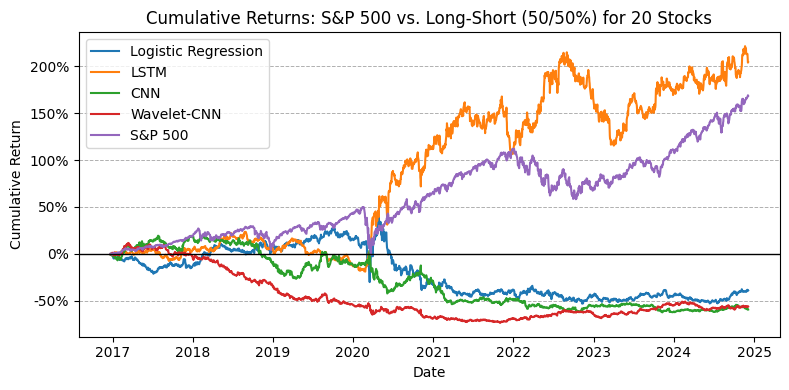

In [26]:
def plot_cumulative_returns(performance_lr, performance_lstm, performance_cnn, performance_wavelet_cnn, k=10, long_pct=0.5, transaction_cost=transaction_cost):
    """
    Plots cumulative returns for Logistic Regression, LSTM, and CNN strategies.

    Parameters:
        - performance_lr, performance_lstm, performance_cnn: pd.DataFrame
          DataFrames with 'date' and 'net_return' columns.
        
        - k (int): Number of stocks traded per side (total stocks traded = 2 * k).
        
        - long_pct (float): Percentage split of long positions.
        
        - transaction_cost (float): Fractional transaction cost per trade. 
                                    e.g. 0.0002 => 2 bps. Default = 0.0 (no cost).
    """
    
    # Produce SP500 returns
    performance_sp500 = slice_sp500_to_reference(market_data_df, performance_lr)

    # Ensure date columns are in correct format
    performance_lr['date'] = pd.to_datetime(performance_lr['date'])
    performance_lstm['date'] = pd.to_datetime(performance_lstm['date'])
    performance_cnn['date'] = pd.to_datetime(performance_cnn['date'])
    performance_wavelet_cnn['date'] = pd.to_datetime(performance_wavelet_cnn['date'])
    performance_sp500['date'] = pd.to_datetime(performance_sp500['date'])

    # Compute cumulative returns
    performance_lr['cum_return'] = (1 + performance_lr['net_return']).cumprod() - 1
    performance_lstm['cum_return'] = (1 + performance_lstm['net_return']).cumprod() - 1
    performance_cnn['cum_return'] = (1 + performance_cnn['net_return']).cumprod() - 1
    performance_wavelet_cnn['cum_return'] = (1 + performance_wavelet_cnn['net_return']).cumprod() - 1
    performance_sp500['cum_return'] = (1 + performance_sp500['net_return']).cumprod() - 1

    plt.figure(figsize=(8, 4))

    # Plot each model
    plt.plot(performance_lr['date'], performance_lr['cum_return'] * 100, label='Logistic Regression')
    plt.plot(performance_lstm['date'], performance_lstm['cum_return'] * 100, label='LSTM')
    plt.plot(performance_cnn['date'], performance_cnn['cum_return'] * 100, label='CNN')
    plt.plot(performance_wavelet_cnn['date'], performance_wavelet_cnn['cum_return'] * 100, label='Wavelet-CNN')
    plt.plot(performance_sp500['date'], performance_sp500['cum_return'] * 100, label='S&P 500')

    # Solid horizontal line at zero
    plt.axhline(y=0, color='black', linewidth=1.0)

    # Dashed grid lines for y-axis, none for x-axis
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.grid(axis='x', visible=False)

    # Dynamic title logic for the long/short split
    if long_pct == 1.0:
        title_long_short = '100% Long'
    elif long_pct == 0.0:
        title_long_short = '100% Short'
    elif long_pct == 0.5:
        title_long_short = '50/50%'
    else:
        title_long_short = f"{int(long_pct*100.0)}/{int((1 - long_pct)*100.0)}%"

    # Dynamic logic for transaction cost
    if transaction_cost > 0:
        bps = transaction_cost * 10_000
        tc_string = f" with {bps:.2f} bps Transaction Costs"
    else:
        tc_string = ""

    plt.title(
        f"Cumulative Returns: S&P 500 vs. Long-Short ({title_long_short}) "
        f"for {2*k} Stocks{tc_string}"
    )

    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")

    # Format y-axis as percentage
    def to_percent(y, _):
        return f"{y:.0f}%"
 
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(50))
       
    # Display axis frames
    for spine in plt.gca().spines.values():
        spine.set_visible(True)

    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

plot_cumulative_returns(performance_lr_df, performance_lstm_df, performance_cnn_df, performance_wavelet_cnn_df, k=k, long_pct = long_pct, transaction_cost=transaction_cost)

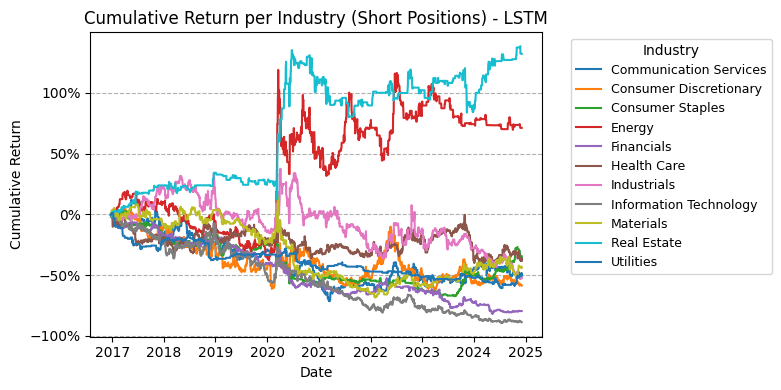

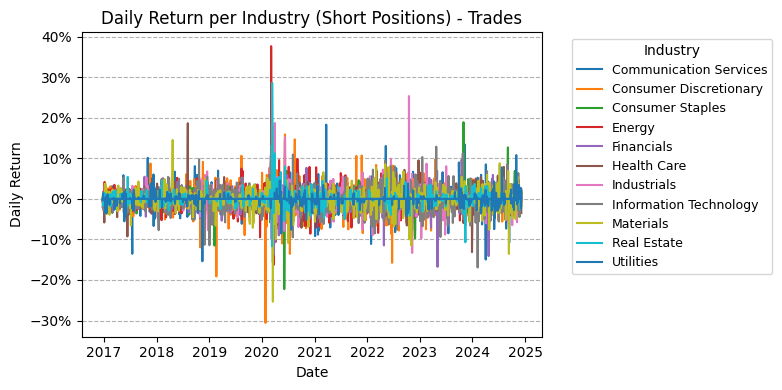

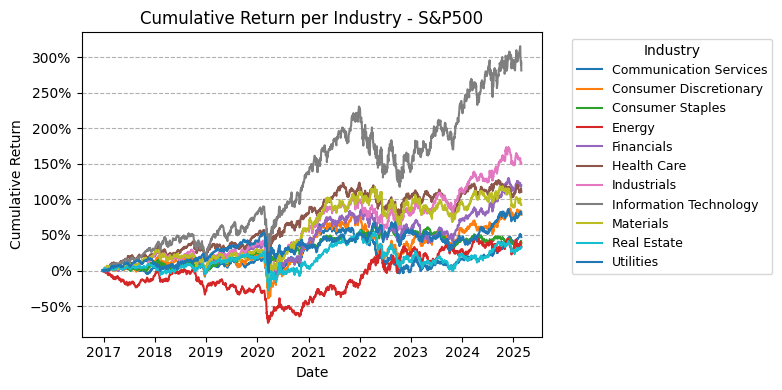

In [170]:
def plot_returns_by_industry(trades_df, daily_stock_data_df, position='net'):
    """
    Plots cumulative and daily returns per industry for the model's trades, 
    and also includes the industry-wise performance of the stock universe.
    Ensures all plots start from the same initial date.
    
    Parameters
    ----------
    trades_df : pd.DataFrame
        DataFrame containing at least:
           - 'date': date of the trade/return.
           - 'ticker': stock ticker.
           - 'return_next': daily return in decimal form (e.g., 0.01 for 1%).
           - 'position': string, either 'long' or 'short'.
    daily_stock_data_df : pd.DataFrame
        DataFrame with at least:
           - 'date': date of the stock return.
           - 'ticker': stock ticker.
           - 'return': daily return of the stock.
           - 'industry': industry classification of the stock.
    position : str, optional
        Which return to plot for trades_df:
          - 'net': all trades, with short returns flipped.
          - 'long': only long positions.
          - 'short': only short positions (with sign flipped so that positive indicates profit).
    
    Returns
    -------
    None
        Displays three plots:
        1. Cumulative returns per industry (trades).
        2. Daily returns per industry (trades).
        3. Cumulative returns per industry (stock universe).
    """
    
    # 1. Merge trades_df with industry info based on ticker.
    ticker_industry_map = daily_stock_data_df[['ticker', 'industry']].drop_duplicates(subset=['ticker'])
    merged = pd.merge(trades_df, ticker_industry_map, on='ticker', how='left')
    
    # 2. Convert date column to datetime and sort.
    merged['date'] = pd.to_datetime(merged['date'])
    merged.sort_values('date', inplace=True)

    # Find the minimum date in trades_df to align stock universe plot
    min_trade_date = merged['date'].min()
    
    # 3. Create an adjusted return column based on the 'position' toggle.
    if position == 'net':
        merged['adj_return'] = np.where(
            merged['position'] == 'short',
            -merged['return_next'],
            merged['return_next']
        )
    elif position == 'long':
        merged = merged[merged['position'] == 'long'].copy()
        merged['adj_return'] = merged['return_next']
    elif position == 'short':
        merged = merged[merged['position'] == 'short'].copy()
        merged['adj_return'] = -merged['return_next']
    else:
        raise ValueError("position must be one of 'net', 'long', or 'short'")
    
    # 4. Compute equal-weighted daily return per industry for the trades.
    daily_industry_trades = (
        merged.groupby(['date', 'industry'])['adj_return']
        .mean()
        .reset_index(name='daily_return')
    )
    
    # 5. Pivot so that each industry becomes a column.
    daily_pivot_trades = daily_industry_trades.pivot(index='date', columns='industry', values='daily_return')
    daily_pivot_trades_filled = daily_pivot_trades.fillna(0)

    # 6. Compute cumulative returns per industry for the trades.
    cum_returns_trades = (1 + daily_pivot_trades_filled).cumprod() - 1

    # ---------------------------
    # Plot 1: Cumulative Returns (Trades)
    # ---------------------------
    plt.figure(figsize=(8, 4))
    for col in cum_returns_trades.columns:
        plt.plot(cum_returns_trades.index, cum_returns_trades[col], label=str(col))
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(f"Cumulative Return per Industry ({position.capitalize()} Positions) - LSTM")
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax.grid(False, axis='x')  
    ax.grid(True, axis='y', linestyle='--')  
    ax.set_axisbelow(True)
    
    plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Plot 2: Daily Returns (Trades)
    # ---------------------------
    plt.figure(figsize=(8, 4))
    for col in daily_pivot_trades_filled.columns:
        plt.plot(daily_pivot_trades_filled.index, daily_pivot_trades_filled[col], label=str(col))
    plt.xlabel("Date")
    plt.ylabel("Daily Return")
    plt.title(f"Daily Return per Industry ({position.capitalize()} Positions) - Trades")
    
    ax2 = plt.gca()
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax2.grid(False, axis='x')  
    ax2.grid(True, axis='y', linestyle='--')  
    ax2.set_axisbelow(True)
    
    plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Plot 3: Cumulative Returns (Stock Universe)
    # ---------------------------
    daily_stock_data_df['date'] = pd.to_datetime(daily_stock_data_df['date'])

    # Filter stock universe data to start at the same date as trades_df
    daily_stock_data_df = daily_stock_data_df[daily_stock_data_df['date'] >= min_trade_date]
    
    # Compute equal-weighted industry-level daily return for the full stock universe
    daily_industry_market = (
        daily_stock_data_df.groupby(['date', 'industry'])['return']
        .mean()
        .reset_index(name='daily_return')
    )

    daily_pivot_market = daily_industry_market.pivot(index='date', columns='industry', values='daily_return')
    daily_pivot_market_filled = daily_pivot_market.fillna(0)

    # Compute cumulative returns for the stock universe per industry
    cum_returns_market = (1 + daily_pivot_market_filled).cumprod() - 1

    plt.figure(figsize=(8, 4))
    for col in cum_returns_market.columns:
        plt.plot(cum_returns_market.index, cum_returns_market[col], label=str(col))
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Return per Industry - S&P500")

    ax3 = plt.gca()
    ax3.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax3.grid(False, axis='x')  
    ax3.grid(True, axis='y', linestyle='--')  
    ax3.set_axisbelow(True)

    plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.show()

# Run the function
plot_returns_by_industry(trades_lstm_df, daily_stock_data_df, position='short')

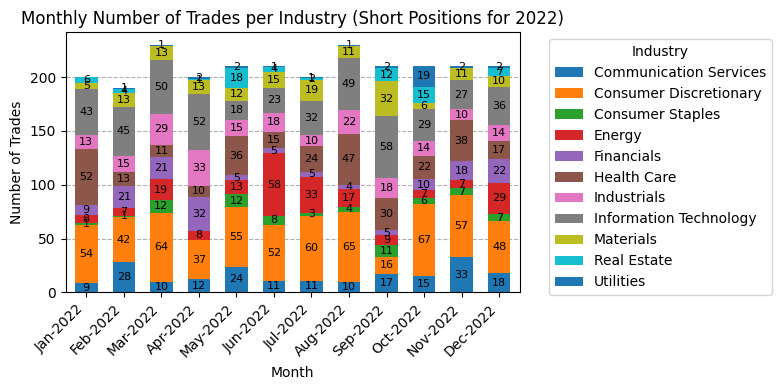

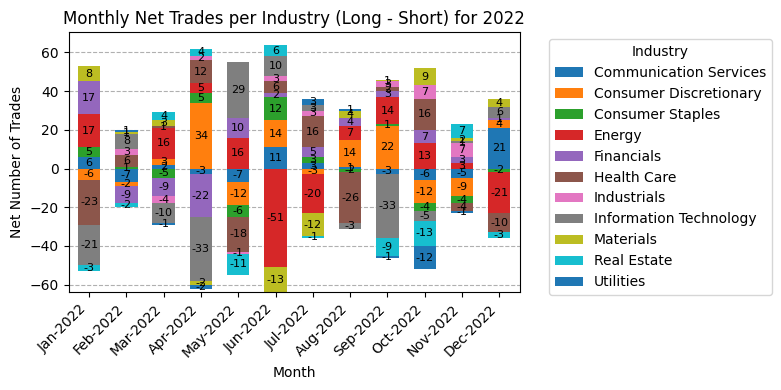

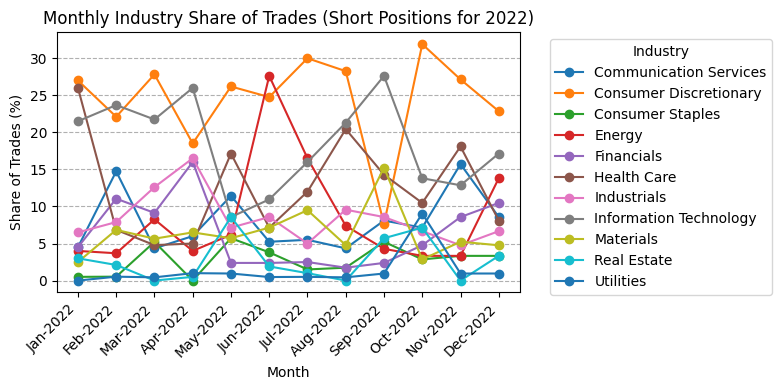

In [157]:
def plot_monthly_trade_counts_shares_and_net(trades_df, daily_stock_data_df, position='all', year=None):
    """
    Creates three plots for monthly trade activity:
      1. A stacked bar chart of total trades per industry (filtered by the 'position' parameter).
      2. A stacked bar chart of net trades per industry, where net trades = (# long trades - # short trades).
         (This is computed using all trades regardless of the position filter.)
      3. A line chart showing each industry's percentage share of total monthly trades (filtered by the 'position').
    
    All x-axis labels are formatted as 'Jan-2020', 'Feb-2020', etc. The grid displays dashed horizontal lines only.
    
    Parameters
    ----------
    trades_df : pd.DataFrame
        Must contain at least:
          - 'date': date of the trade (string or datetime).
          - 'ticker': stock ticker.
          - 'position': string, either 'long' or 'short'.
        Each row represents a trade.
    
    daily_stock_data_df : pd.DataFrame
        DataFrame with at least:
          - 'ticker'
          - 'industry'
        (Assumes each ticker has a stable industry classification.)
    
    position : str, optional
        Which trades to include for the filtered plots:
          - 'all': Include all trades (both long and short).
          - 'long': Only include long trades.
          - 'short': Only include short trades.
    
    year : int or None, optional
        If an integer is provided (e.g., 2022), the function filters the data for that year.
        If None, all years are included.
    
    Returns
    -------
    None
        Displays three plots in order:
          1. Stacked bar chart of total trades.
          2. Stacked bar chart of net trades (long minus short).
          3. Line chart of industry percentage shares.
    """
    
    # ----------------------------
    # Common Preprocessing Steps
    # ----------------------------
    # Merge trades with industry mapping (assume industry is stable per ticker)
    ticker_industry_map = daily_stock_data_df[['ticker', 'industry']].drop_duplicates(subset=['ticker'])
    merged = pd.merge(trades_df, ticker_industry_map, on='ticker', how='left')
    
    # Convert 'date' to datetime and sort
    merged['date'] = pd.to_datetime(merged['date'])
    merged.sort_values('date', inplace=True)
    
    # If a year filter is provided, apply it
    if year is not None:
        merged = merged[merged['date'].dt.year == year]
    
    # Create a monthly period column
    merged['year_month'] = merged['date'].dt.to_period('M')
    
    # Save a copy of the unfiltered-by-position data for net trades calculation
    merged_all = merged.copy()
    
    # ----------------------------
    # Plot 1: Total Trades Stacked Bar (Filtered by Position)
    # ----------------------------
    # Filter by position if needed for Plot 1 and Plot 3
    if position == 'long':
        merged_filtered = merged[merged['position'] == 'long'].copy()
    elif position == 'short':
        merged_filtered = merged[merged['position'] == 'short'].copy()
    elif position == 'all':
        merged_filtered = merged.copy()
    else:
        raise ValueError("position must be 'all', 'long', or 'short'")
    
    # Group filtered data by month and industry to count trades
    monthly_trades = (
        merged_filtered.groupby(['year_month', 'industry'])
        .size()
        .reset_index(name='n_trades')
    )
    
    # Pivot so rows = month and columns = industry
    pivot_total = monthly_trades.pivot(index='year_month', columns='industry', values='n_trades').fillna(0)
    pivot_total.index = pivot_total.index.to_timestamp()
    month_labels = pivot_total.index.strftime('%b-%Y')
    
    # Plot stacked bar for total trades with reduced bar width (e.g., 0.6)
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    pivot_total.plot(kind='bar', stacked=True, ax=ax1, width=0.6)
    
    # Annotate each segment
    for patch in ax1.patches:
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_y() + height / 2
            ax1.text(x, y, int(height), ha='center', va='center', fontsize=8, color='black')
    
    pos_label = {'all': 'All (Long & Short)', 'long': 'Long', 'short': 'Short'}[position]
    year_label = f" for {year}" if year is not None else ""
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Number of Trades")
    ax1.set_title(f"Monthly Number of Trades per Industry ({pos_label} Positions{year_label})")
    ax1.set_xticks(range(len(month_labels)))
    ax1.set_xticklabels(month_labels, rotation=45, ha='right')
    ax1.grid(False, axis='x')
    ax1.grid(True, axis='y', linestyle='--')
    ax1.set_axisbelow(True)
    ax1.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # ----------------------------
    # Plot 2: Net Trades Stacked Bar (Long - Short, from all trades)
    # ----------------------------
    # Compute monthly counts separately for long and short from merged_all
    long_trades = (
        merged_all[merged_all['position'] == 'long']
        .groupby(['year_month', 'industry'])
        .size()
        .reset_index(name='n_long')
    )
    short_trades = (
        merged_all[merged_all['position'] == 'short']
        .groupby(['year_month', 'industry'])
        .size()
        .reset_index(name='n_short')
    )
    
    # Merge the counts and fill missing values with 0
    monthly_net = pd.merge(long_trades, short_trades, on=['year_month', 'industry'], how='outer').fillna(0)
    monthly_net['net_trades'] = monthly_net['n_long'] - monthly_net['n_short']
    
    # Pivot for net trades
    pivot_net = monthly_net.pivot(index='year_month', columns='industry', values='net_trades').fillna(0)
    pivot_net.index = pivot_net.index.to_timestamp()
    net_labels = pivot_net.index.strftime('%b-%Y')
    
    # Plot stacked bar for net trades with reduced bar width
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    pivot_net.plot(kind='bar', stacked=True, ax=ax2, width=0.6)
    
    # Annotate each bar segment (allow negative values)
    for patch in ax2.patches:
        height = patch.get_height()
        if height != 0:
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_y() + height / 2
            ax2.text(x, y, f"{int(height)}", ha='center', va='center', fontsize=8, color='black')
    
    ax2.set_xlabel("Month")
    ax2.set_ylabel("Net Number of Trades")
    ax2.set_title(f"Monthly Net Trades per Industry (Long - Short){year_label}")
    ax2.set_xticks(range(len(net_labels)))
    ax2.set_xticklabels(net_labels, rotation=45, ha='right')
    ax2.grid(False, axis='x')
    ax2.grid(True, axis='y', linestyle='--')
    ax2.set_axisbelow(True)
    ax2.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # ----------------------------
    # Plot 3: Industry % Share (Line Chart) from filtered data
    # ----------------------------
    total_trades_filtered = pivot_total.sum(axis=1)
    percent_share = pivot_total.div(total_trades_filtered, axis=0) * 100
    
    fig3, ax3 = plt.subplots(figsize=(8, 4))
    for col in percent_share.columns:
        ax3.plot(range(len(percent_share.index)), percent_share[col], marker='o', label=str(col))
    
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Share of Trades (%)")
    ax3.set_title(f"Monthly Industry Share of Trades ({pos_label} Positions{year_label})")
    ax3.set_xticks(range(len(month_labels)))
    ax3.set_xticklabels(month_labels, rotation=45, ha='right')
    ax3.grid(False, axis='x')
    ax3.grid(True, axis='y', linestyle='--')
    ax3.set_axisbelow(True)
    ax3.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_monthly_trade_counts_shares_and_net(trades_lstm_df, daily_stock_data_df, position='short', year=2022)

In [132]:
def summarize_models_performance(model_names, performance_dfs):
    metrics_summary = []

    for model_name, df in zip(model_names, performance_dfs):
        metrics = summarize_performance(df)

        metrics_list = {
            "Model": model_name,
            "Mean Return (Long) %": metrics['mean_return_long'] *100, 
            "Mean Return (Short) %": metrics['mean_return_short'] *100,
            "Mean Return (Net) %": metrics['mean_return_net'] *100,
            "Standard Error %": metrics['standard_error_net'] *100,
            "T-Statistic": metrics['t_stat_net'],
            "Min %": metrics['min_net'] *100,
            "Q1 %": metrics['q1_net'] *100,
            "Median %": metrics['median_net'] *100,
            "Q3 %": metrics['q3_net'] *100,
            "Max %": metrics['max_net'] *100,
            "Share % > 0": metrics['share_positive'] *100,
            "Std Dev %": metrics['std_net'] *100,
            "Skewness": metrics['skew_net'],
            "Kurtosis": metrics['kurt_net'],
            "1% VaR": metrics['var_1'] *100,
            "1% CVaR": metrics['cvar_1'] *100,
            "5% VaR": metrics['var_5'] *100,
            "5% CVaR": metrics['cvar_5'] *100,
            "Max Drawdown %": metrics['max_drawdown'] *100,
            "Return % p.a.": metrics['return_pa'] *100,
            "Std Dev % p.a.": metrics['std_pa'] *100,
            "Downside % Dev p.a.": metrics['downside_dev_pa'] *100,
            "Sharpe p.a.": metrics['sharpe_pa'],
            "Sortino p.a.": metrics['sortino_pa'],
        }

        metrics_summary.append(metrics_list)

    summary_df = pd.DataFrame(metrics_summary)
    return summary_df

# Example usage:
model_names = ['Logistic Regression', 'LSTM', 'CNN', 'Wavelet-CNN']
performance_dfs = [performance_lr_df, performance_lstm_df, performance_cnn_df, performance_wavelet_cnn_df]

summary_table = summarize_models_performance(model_names, performance_dfs)
summary_table

,Model,Mean Return (Long) %,Mean Return (Short) %,Mean Return (Net) %,Standard Error %,T-Statistic,Min %,Q1 %,Median %,Q3 %,Max %,Share % > 0,Std Dev %,Skewness,Kurtosis,1% VaR,1% CVaR,5% VaR,5% CVaR,Max Drawdown %,Return % p.a.,Std Dev % p.a.,Downside % Dev p.a.,Sharpe p.a.,Sortino p.a.
0,Logistic Regression,0.057,-0.066,-0.009,0.039,-0.238,-16.439,-0.796,-0.008,0.771,13.819,49.650,1.757,-0.227,10.622,-5.027,-7.105,-2.529,-4.170,-66.386,-2.353,27.898,21.193,-0.084,-0.111
1,LSTM,0.079,-0.013,0.066,0.033,2.023,-9.864,-0.725,0.009,0.819,8.604,50.400,1.468,0.381,4.923,-3.893,-4.967,-2.191,-3.161,-34.417,16.739,23.307,15.115,0.718,1.107
2,CNN,0.024,-0.058,-0.035,0.032,-1.072,-10.349,-0.738,0.020,0.756,7.683,50.900,1.447,-0.635,4.507,-4.375,-5.874,-2.468,-3.656,-68.559,-8.738,22.970,17.865,-0.380,-0.489
3,Wavelet-CNN,0.013,-0.044,-0.031,0.031,-1.001,-13.156,-0.759,-0.038,0.724,7.996,48.600,1.403,-0.379,7.173,-3.709,-5.457,-2.185,-3.304,-76.460,-7.916,22.276,16.256,-0.355,-0.487


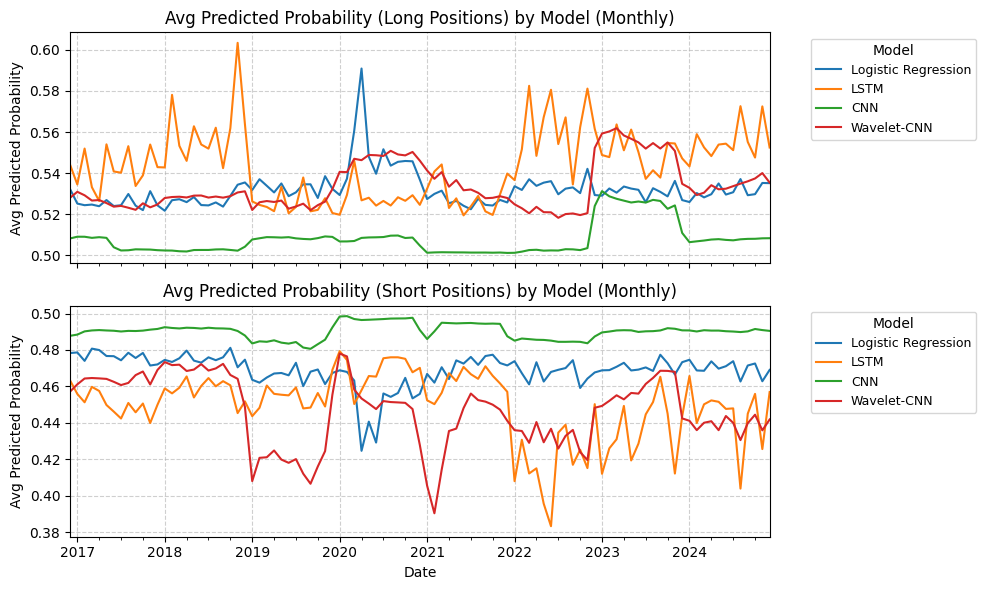

In [ ]:
def plot_avg_predicted_prob_monthly(trades_dfs, model_names):
    """
    Plots the average predicted probability per month for each model, 
    split by position type (long/short).
    
    Parameters
    ----------
    trades_dfs : list of pd.DataFrame
        List of trade DataFrames, each corresponding to a different model.
        Each DataFrame should contain:
        - 'date': trade date
        - 'predicted_prob': probability assigned by the model
        - 'position': either 'long' or 'short'
    model_names : list of str
        List of model names corresponding to the trade DataFrames.
    
    Returns
    -------
    None
        Displays two plots: one for long positions and one for short positions.
    """
    
    # Store model results
    avg_pred_prob_long = []
    avg_pred_prob_short = []

    for trades_df, model_name in zip(trades_dfs, model_names):
        # Ensure date is in datetime format
        trades_df['date'] = pd.to_datetime(trades_df['date'])

        # Create a year-month column for grouping
        trades_df['year_month'] = trades_df['date'].dt.to_period('M')

        # Compute mean predicted probability per month
        long_probs = (
            trades_df[trades_df['position'] == 'long']
            .groupby('year_month')['predicted_prob']
            .mean()
            .rename(model_name)
        )
        short_probs = (
            trades_df[trades_df['position'] == 'short']
            .groupby('year_month')['predicted_prob']
            .mean()
            .rename(model_name)
        )

        # Append to list
        avg_pred_prob_long.append(long_probs)
        avg_pred_prob_short.append(short_probs)

    # Combine into DataFrames
    avg_pred_prob_long_df = pd.concat(avg_pred_prob_long, axis=1)
    avg_pred_prob_short_df = pd.concat(avg_pred_prob_short, axis=1)

    # Convert period index back to datetime for plotting
    avg_pred_prob_long_df.index = avg_pred_prob_long_df.index.to_timestamp()
    avg_pred_prob_short_df.index = avg_pred_prob_short_df.index.to_timestamp()

    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot for long positions
    avg_pred_prob_long_df.plot(ax=axes[0], legend=True)
    axes[0].set_title("Avg Predicted Probability (Long Positions) by Model (Monthly)")

    # Plot for short positions
    avg_pred_prob_short_df.plot(ax=axes[1], legend=True)
    axes[1].set_title("Avg Predicted Probability (Short Positions) by Model (Monthly)")

    # Formatting
    axes[1].set_xlabel("Date")
    for ax in axes:
        ax.set_ylabel("Avg Predicted Probability")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

    plt.tight_layout()
    plt.show()

# Example usage
plot_avg_predicted_prob_monthly(
    [trades_lr_df, trades_lstm_df, trades_cnn_df, trades_wavelet_cnn_df], 
    ["Logistic Regression", "LSTM", "CNN", "Wavelet-CNN"]
)

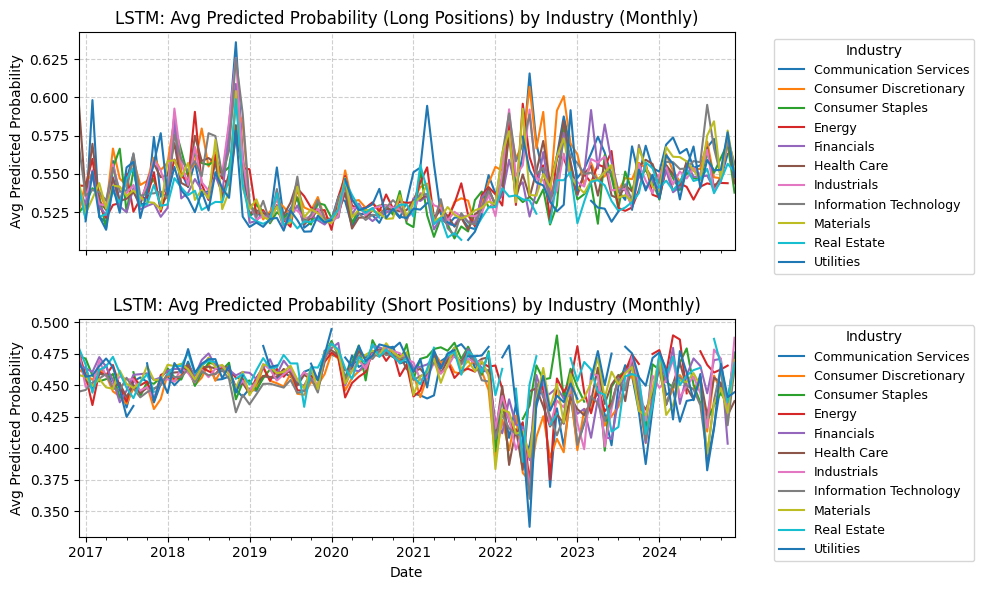

In [ ]:
def plot_avg_predicted_prob_by_industry_monthly(trades_df, daily_stock_data_df):
    """
    Plots the average predicted probability per month for the LSTM model, 
    split by industry and position type (long/short).
    
    Parameters
    ----------
    trades_df : pd.DataFrame
        DataFrame containing LSTM trades, with columns:
        - 'date': trade date
        - 'ticker': stock ticker
        - 'predicted_prob': probability assigned by the model
        - 'position': either 'long' or 'short'
    daily_stock_data_df : pd.DataFrame
        DataFrame containing industry classification for tickers, with columns:
        - 'ticker': stock ticker
        - 'industry': industry sector
    
    Returns
    -------
    None
        Displays two plots: one for long positions and one for short positions, each split by industry.
    """
    
    # Ensure date is in datetime format
    trades_df['date'] = pd.to_datetime(trades_df['date'])

    # Merge trades with industry classification
    trades_df = trades_df.merge(daily_stock_data_df[['ticker', 'industry']].drop_duplicates(), on='ticker', how='left')

    # Create a year-month column for grouping
    trades_df['year_month'] = trades_df['date'].dt.to_period('M')

    # Group by year_month and industry to compute mean predicted probability per industry
    industry_long = (
        trades_df[trades_df['position'] == 'long']
        .groupby(['year_month', 'industry'])['predicted_prob']
        .mean()
        .unstack()
    )
    industry_short = (
        trades_df[trades_df['position'] == 'short']
        .groupby(['year_month', 'industry'])['predicted_prob']
        .mean()
        .unstack()
    )

    # Convert period index back to datetime for plotting
    industry_long.index = industry_long.index.to_timestamp()
    industry_short.index = industry_short.index.to_timestamp()

    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot for long positions
    industry_long.plot(ax=axes[0], legend=True)
    axes[0].set_title("LSTM: Avg Predicted Probability (Long Positions) by Industry (Monthly)")

    # Plot for short positions
    industry_short.plot(ax=axes[1], legend=True)
    axes[1].set_title("LSTM: Avg Predicted Probability (Short Positions) by Industry (Monthly)")

    # Formatting
    axes[1].set_xlabel("Date")
    for ax in axes:
        ax.set_ylabel("Avg Predicted Probability")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

    plt.tight_layout()
    plt.show()

# Example usage
plot_avg_predicted_prob_by_industry_monthly(trades_lstm_df, daily_stock_data_df)

In [176]:
# Merge trades with industry classification
trades_with_industry = trades_lstm_df.merge(
    daily_stock_data_df[['ticker', 'industry']], on='ticker', how='left'
)

# Count trades per industry and position
trade_counts = trades_with_industry.groupby(['industry', 'position']).size().unstack(fill_value=0)

# Compute percentages relative to total long and short trades
industry_long_share = (trade_counts['long'] / trade_counts['long'].sum()) * 100
industry_short_share = (trade_counts['short'] / trade_counts['short'].sum()) * 100

# Combine into a single dataframe
industry_trade_shares = pd.DataFrame({
    'Long Share (%)': industry_long_share,
    'Short Share (%)': industry_short_share
}).fillna(0)  # Fill NaNs where there were no trades in one category

# Display the result
industry_trade_shares

,Long Share (%),Short Share (%)
industry,,
Communication Services,6.052,6.163
Consumer Discretionary,18.964,20.129
Consumer Staples,6.272,5.627
Energy,9.238,9.574
Financials,9.608,8.143
Health Care,11.810,11.805
Industrials,10.426,9.801
Information Technology,14.178,16.628
Materials,6.505,6.512
